In [2]:
# imports
import os
import sys
import pickle
import torch
import re
import spacy
import tqdm
import nltk
import en_core_web_sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from torch import nn
from spacy import displacy
from collections import defaultdict
from collections import Counter

working_dir = '../src/models'
sys.path.append(os.path.abspath(working_dir))
sys.path.append(os.path.abspath('..'))
from use_evaluation_model_rotate import load_data
from api import EvaluationModel, NegSampleGenerator
from src.models.conve import ConvE

In [3]:
import mlflow.tracking
import mlflow.pytorch
from mlflow.store.artifact_repository_registry import get_artifact_repository


run_id = '114a877506194604bf63a6a7f6c7f0e3'
tmp_dir = '/tmp/conve-evaluation-results'
client = mlflow.tracking.MlflowClient()
artifacts = client.list_artifacts(run_id)
artifacts = [f.path for f in artifacts 
                 if f.path not in ["conve-evaluation-results.npy", "conve-evaluation-results.pickle.npy"]
            ]

for a in artifacts:
    run = client.get_run(run_id)
    artifact_root = run.info.artifact_uri
    artifact_repo = get_artifact_repository(artifact_root)
    artifact_repo.download_artifacts(a, dst_path=tmp_dir)

# paths etc.
model_output_path = tmp_dir
model_path = None
data_path = '../data/processed/FB15k-237'

In [4]:
os.listdir(tmp_dir)

['prediction_table_tail.pkl',
 'worst_predictions_head.pkl',
 'avg_position_table_head.pkl',
 'worst_predictions_tail.pkl',
 'compare_head_tail.pkl',
 'highly_ranked_table_tail.pkl',
 'highly_ranked_table_head.pkl',
 'scores_cdf.png',
 'avg_position_table_tail.pkl',
 'top_ranked_table_tail.pkl',
 'best_predictions_tail.pkl',
 'top_ranked_table_head.pkl',
 'scores.png',
 'best_predictions_head.pkl',
 'prediction_table_head.pkl']

In [5]:
# load data and dicts needed for model analysis

# train, valid and test triples
train_triples, valid_triples, test_triples = load_data(data_path)
all_true_triples = np.concatenate([train_triples, valid_triples,
                                   test_triples], axis=0)

# dictionaries to translate IDs into normal words (and vice versa)
path = os.path.join(data_path, 'id_to_relation.pickle')
id2relation = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'relation_to_id.pickle')
relation2id = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'id_to_entity.pickle')
id2entity = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'entity_to_id.pickle')
entity2id = pickle.load(open(path, 'rb'))

path = os.path.join(data_path[:-10], 'mid2name.pkl')
mid2name = pickle.load(open(path, 'rb'))  # only strings!

name2mid = {name: mid for mid, name in mid2name.items()}

# count number of occurences of head entities, relations and tail entities in train
count_head_entities_train = defaultdict(int)
count_relations_train = defaultdict(int)
count_tail_entities_train = defaultdict(int)
for (s, p, o) in train_triples:
    count_head_entities_train[s] += 1
    count_relations_train[p] += 1
    count_tail_entities_train[o] += 1

# count number of occurences of head entities, relations and tail entities in test
count_head_entities_test = defaultdict(int)
count_relations_test = defaultdict(int)
count_tail_entities_test = defaultdict(int)
for (s, p, o) in test_triples:
    count_head_entities_test[s] += 1
    count_relations_test[p] += 1
    count_tail_entities_test[o] += 1

# count how often head-relation and relation-tail combinations occur
path = os.path.join(data_path, 'id_to_relation.pickle')
relations = set(pickle.load(open(path, 'rb')).keys())

head_rel_count = defaultdict(int)
rel_tail_count = defaultdict(int)
head_tail_count = defaultdict(int)
for triples in [train_triples, valid_triples, test_triples]:
    for (s, p, o) in triples:
        head_rel_count[s,p] += 1
        rel_tail_count[p,o] += 1
        head_tail_count[s,o] += 1
        
# categorize relationships into 0 = 1:1, 1 = 1:n, 2 = n:1, 3 = n:m
relation2type = dict()
for relation in relations:
    subject_counts = []
    object_counts = []
    considered_sp_tuples = set()
    considered_po_tuples = set()
    for triples in [train_triples, valid_triples, test_triples]:
        for (s, p, o) in triples:
            if relation == p:
                if (s, p) not in considered_sp_tuples:
                    considered_sp_tuples.add((s, p))
                    subject_counts.append(head_rel_count[(s, p)])
                if (p, p) not in considered_po_tuples:
                    considered_po_tuples.add((p, o))
                    object_counts.append(rel_tail_count[(p, o)])
                
    avg_subject_count = sum(subject_counts) / len(subject_counts)
    avg_object_count = sum(object_counts) / len(object_counts)

    if avg_subject_count < 1.5 and avg_object_count < 1.5:  # 
        relation2type[relation] = '1:1'  # 11 relations in the FB15k-237 dataset
    elif avg_subject_count < 1.5:
        relation2type[relation] = '1:n'  # 87 relations in the FB15k-237 dataset
    elif avg_object_count < 1.5:
        relation2type[relation] = 'n:1'  # 16 relations in the FB15k-237 dataset
    else:
        relation2type[relation] = 'n:m'  # 123 relations in the FB15k-237 dataset

assert sum(Counter(relation2type.values()).values()) == len(relations)

In [6]:
# create NERTagger
path1_classifier = '/home/ubuntu/sarah/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz'
path2_classifier = '/home/ubuntu/sarah/stanford-ner-2018-10-16/stanford-ner.jar'
st = StanfordNERTagger(path1_classifier, path2_classifier, encoding='utf-8')
nlp = en_core_web_sm.load()

# helper functions
all_triples = set(tuple(triple) for triple in all_true_triples)
error_id2description_head = {0: 'predicted head is actually correct',  # something went wrong!
                             1: 'predicted head is similar to true head, but not the same',
                             2: 'predicted head = given tail',
                             3: 'predicted head neither occured together with given relation nor with given tail',
                             4: 'predicted head and given relation never occured together',
                             5: 'predicted head and given tail never occured together',
                             6: 'wrong named entity type',
                             7: 'predicted head has correct named entity type and occured with the given relation'}

error_id2description_tail = {0: 'predicted tail is actually correct',  # something went wrong!
                             1: 'predicted tail is similar to true tail, but not the same',
                             2: 'predicted tail = given head',
                             3: 'predicted tail neither occured together with given relation nor with given head',
                             4: 'predicted tail and given relation never occured together',
                             5: 'predicted tail and given head never occured together',
                             6: 'wrong named entity type',
                             7: 'predicted tail has correct named entity type and occured with the given relation'}

def get_error_type(triple, predicted, mode):
    true_head_id = entity2id[name2mid[triple[0]]]
    true_relation_id = relation2id[triple[1]]
    true_tail_id = entity2id[name2mid[triple[2]]]
    error_type = set()

    if mode == 'head':
        predicted_head_id = entity2id[name2mid[predicted]]
        predicted_triple = tuple([predicted_head_id, true_relation_id, true_tail_id])
        if predicted_triple in all_triples:
            error_type.add(0)
        if triple[0] in predicted or predicted in triple[0]:
            error_type.add(1) 
    
        if predicted == triple[2]:
            error_type.add(2)
        current_head_rel_count = head_rel_count[(predicted_head_id, true_relation_id)]
        current_head_tail_count = head_tail_count[(predicted_head_id, true_tail_id)]
        if current_head_rel_count == 0 and current_head_tail_count == 0:
            error_type.add(3)
        if current_head_rel_count == 0:
            error_type.add(4)
        if current_head_tail_count == 0:
            error_type.add(5)
            
        ner_result1_correct_head = [ent.label_ for ent in nlp(triple[0]).ents]
        ner_result1_predicted_head = [ent.label_ for ent in nlp(predicted).ents]
        ner_result2_correct_head = st.tag(word_tokenize(triple[0]))
        ner_result2_correct_head = [tag for (word, tag) in ner_result2_correct_head]
        ner_result2_predicted_head = st.tag(word_tokenize(predicted))
        ner_result2_predicted_head = [tag for (word, tag) in ner_result2_predicted_head]
        
        if len(ner_result1_correct_head) > 0 and len(ner_result1_predicted_head) > 0:
            if ner_result1_correct_head != ner_result1_predicted_head \
            and ner_result2_correct_head != ner_result2_predicted_head:
                error_type.add(6)

        elif ner_result2_correct_head != ner_result2_predicted_head:
            error_type.add(6)
            
        elif ner_result1_correct_head == ner_result1_predicted_head \
        and ner_result2_correct_head == ner_result2_predicted_head \
        and current_head_rel_count > 0:  # and current_head_tail_count > 0
            error_type.add(7)  # predicted head could theoretically be true?

    elif mode == 'tail':
        predicted_tail_id = entity2id[name2mid[predicted]]

        predicted_triple = tuple([true_head_id, true_relation_id, predicted_tail_id])
        if predicted_triple in all_triples:
            error_type.add(0)
        
        if triple[2] in predicted or predicted in triple[2]:
            error_type.add(1) 
    
        if predicted == triple[0]:
            error_type.add(2)
        
        current_rel_tail_count = rel_tail_count[(true_relation_id, predicted_tail_id)]
        current_head_tail_count = head_tail_count[(true_head_id, predicted_tail_id)]
        if current_rel_tail_count == 0 and current_head_tail_count == 0:
            error_type.add(3)
        
        if current_rel_tail_count == 0:
            error_type.add(4)

        if current_head_tail_count == 0:
            error_type.add(5)

        ner_result1_correct_tail = [ent.label_ for ent in nlp(triple[2]).ents]
        ner_result1_predicted_tail = [ent.label_ for ent in nlp(predicted).ents]
        ner_result2_correct_tail = st.tag(word_tokenize(triple[2]))
        ner_result2_correct_tail = [tag for (word, tag) in ner_result2_correct_tail]
        ner_result2_predicted_tail = st.tag(word_tokenize(predicted))
        ner_result2_predicted_tail = [tag for (word, tag) in ner_result2_predicted_tail]
        
        if len(ner_result1_correct_tail) > 0 and len(ner_result1_predicted_tail) > 0:
            if ner_result1_correct_tail != ner_result1_predicted_tail \
            and ner_result2_correct_tail != ner_result2_predicted_tail:
                error_type.add(6)

        elif ner_result2_correct_tail != ner_result2_predicted_tail:
            error_type.add(6)
            
        elif ner_result1_correct_tail == ner_result1_predicted_tail \
        and ner_result2_correct_tail == ner_result2_predicted_tail \
        and current_rel_tail_count > 0:  # and current_head_tail_count > 0
            error_type.add(7)  # predicted tail could theoretically be true?

    else:
        raise ValueError('mode %s does not exit' % (mode))

    return error_type

In [7]:
class ConveEvaluationModel(EvaluationModel):
    def __init__(self,
                 init_model: ConvE,
                 all_positive_triples: torch.tensor,
                 all_entities: torch.tensor,
                 filter_negatives: bool = True,
                 device: str = 'cpu'):
        """
        Initialzes a ConvE evaluation model.

        Parameters
        ----------
        :params init_model: ConvE
            A trained ConvE model.
        :params all_positive_triples: torch.tensor
            All positive triples including the training and test
            triples.
        :params all_entities: torch.tensor
            All entities in the dataset.
        :params filter_negatives: bool
            If true (default) filter false negative triples.
        """
        self.preferred_device='cuda'
        super(ConveEvaluationModel, self).__init__(None, None,None)
        self.filter_negatives = filter_negatives
        self.all_positive_triples = all_positive_triples
        self.all_entities = all_entities
        self.model = init_model
        preferred_device=device
        self.model.eval()

        self.cache = dict()

        self.device = torch.device(device) or self.model.device

    def get_filter_masks(self, triple):
        """
        Attempts to retrieve the cached mask if available otherwise
        will recompute it.
        """
        if triple not in self.cache:
            subj_mask, obj_mask = self.model._filter_false_negatives(
                triple, self.all_positive_triples, self.all_entities
            )
            self.cache[triple] = (obj_mask, subj_mask)

        return self.cache[triple]

    def predict_object_scores(self, s: torch.tensor, p: torch.tensor,
                              o: torch.tensor) -> torch.tensor:
        batch_size = s.shape[0]

        out_scores = []
        for i in range(batch_size):
            with torch.no_grad():
                scores = self.model.score_objects(s[i],
                                                  p[i])

            if self.filter_negatives:
                triple = [s[i], p[i], o[i]]
                triple = torch.tensor(triple,
                                      dtype=torch.long,
                                      device=self.device)

                obj_mask, _ = self.get_filter_masks(triple)
                obj_mask[o[i]] = True
                scores[obj_mask == 0] = scores.min()

            out_scores.append(scores.view(1, -1))

        return torch.cat(out_scores, dim=0)

    def predict_subject_scores(self, s: torch.tensor, p: torch.tensor,
                               o: torch.tensor) -> torch.tensor:
        batch_size = s.shape[0]

        out_scores = []
        for i in range(batch_size):
            with torch.no_grad():
                scores = self.model.score_subjects(p[i],
                                                   o[i])

            if self.filter_negatives:
                triple = [s[i], p[i], o[i]]
                triple = torch.tensor(triple,
                                      dtype=torch.long,
                                      device=self.device)

                _, subj_mask = self.get_filter_masks(triple)
                subj_mask[s[i]] = True

                scores[subj_mask == 0] = scores.min()

            out_scores.append(scores.view(1, -1))

        return torch.cat(out_scores, dim=0)

In [8]:
# create EvaluationModel that can be used for single predictions
conve_model = mlflow.pytorch.load_model('sftp://sftpuser@10.195.1.54/sftpuser/mlruns/2/0278ec00cc7b47eda553db7c4f66120e/artifacts/models/conve-model-43')

device = torch.device('cuda')
conve_model.device = device

all_positive_triples = np.concatenate([train_triples, valid_triples, test_triples], axis=0)
all_positive_triples = torch.tensor(all_positive_triples,
                                    dtype=torch.long,
                                    device=device)

all_entities = torch.arange(conve_model.num_entities,
                            dtype=torch.long,
                            device=device)

model = ConveEvaluationModel(conve_model, all_positive_triples, all_entities, device='cuda')

/home/ubuntu/.local/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'src.models.conve.ConvE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [8]:
# load prediction_table_head.pkl
path = os.path.join(model_output_path, 'prediction_table_head.pkl')
prediction_table_head = pd.read_pickle(path)
prediction_table_head['rank of true head'] = pd.to_numeric(prediction_table_head['rank of true head'],
                                                           downcast='integer')
s = []
p = []
o = []
topics = []
for _, triple_str in prediction_table_head['triple'].iteritems():
    triple = re.split(',', triple_str[1:-1])
    s.append(int(triple[0].strip()))
    p.append(int(triple[1].strip()))
    o.append(int(triple[2].strip()))
    topics.append(id2relation[int(triple[1].strip())].split('/')[1])

prediction_table_h = pd.DataFrame(columns=['s', 'p', 'o', 'rank'])
prediction_table_h['s'] = s
prediction_table_h['p'] = p
prediction_table_h['o'] = o
prediction_table_h['rank'] = prediction_table_head['rank of true head']
prediction_table_h['topic'] = topics

easy relations for head prediction (10 relations with the lowest average rank):

/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film
/base/eating/practicer_of_diet/diet
/organization/organization/headquarters./location/mailing_address/state_province_region
/music/genre/artists
/sports/sports_league_draft/picks./sports/sports_league_draft_pick/school
/tv/tv_network/programs./tv/tv_network_duration/program
/base/schemastaging/person_extra/net_worth./measurement_unit/dated_money_value/currency
/film/film/story_by
/film/film/runtime./film/film_cut/film_release_region
/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country



difficult relations for head prediction (10 relations with the highest average rank):

/business/business_operation/industry
/business/business_operation/operating_income./measurement_unit/dated_money_value/currency
/people/marriage_union_type/unions_of_this_type./people/marriage/location_of_ceremony
/people/eth

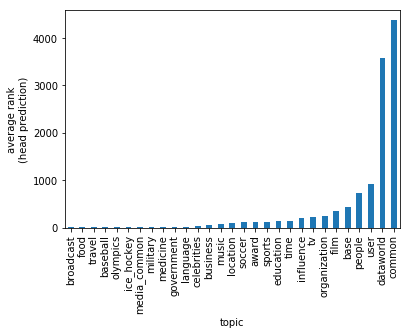

examples for "easy" topics:

example for topic broadcast: /broadcast/content/artist
example for topic food: /food/food/nutrients./food/nutrition_fact/nutrient
example for topic travel: /travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
example for topic baseball: /baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
example for topic olympics: /olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country


examples for "difficult" topics:

example for topic base: /base/popstra/celebrity/dated./base/popstra/dated/participant
example for topic people: /people/person/spouse_s./people/marriage/spouse
example for topic user: /user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy
example for topic dataworld: /dataworld/gardening_hint/split_to
example for topic common: /common/topic/webpage./common/webpage/category


In [9]:
# analyse prediction_table_head.pkl
# find "easy" relations (relations that are part of triples with a good rank) and "difficult" relations
print('easy relations for head prediction (10 relations with the lowest average rank):\n')
for row in prediction_table_h[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank').head(10).iterrows():
    print(id2relation[row[0]])

print('\n\n\ndifficult relations for head prediction (10 relations with the highest average rank):\n')
for row in prediction_table_h[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank', ascending=False).head(10).iterrows():
    print(id2relation[row[0]])
    
print('\n\n\naverage rank of each topic (head prediction):')

df = prediction_table_h[['topic', 'rank']].groupby('topic', as_index=False)['rank'].mean().\
                                           sort_values(by='rank')
ax = df.plot.bar(x='topic', y='rank', rot=90, legend=False).set_ylabel('average rank\n(head prediction)')
plt.show()

# find examples for the "easy" topics
print('examples for "easy" topics:\n')
for index, topic in df.head(5)['topic'].iteritems():
    for index, row in prediction_table_h[['p', 'rank', 'topic']].sort_values(by='rank')[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

print('\n\nexamples for "difficult" topics:\n')
# find examples for the "difficult" topics
for index, topic in df.tail(5)['topic'].iteritems():
    for index, row in prediction_table_h[['p', 'rank', 'topic']].sort_values(by='rank', ascending=False)[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

proportion of relation types: {'n:m': 0.762, '1:n': 0.206, 'n:1': 0.024, '1:1': 0.008}


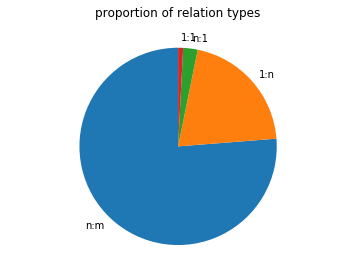

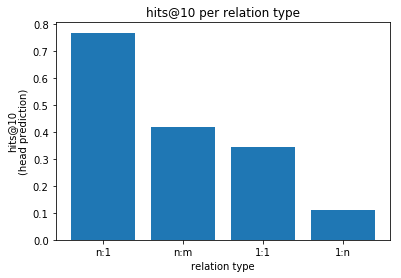

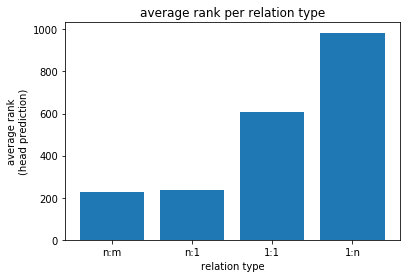

Hint: higher is better for hits@10, lower is better for the average rank



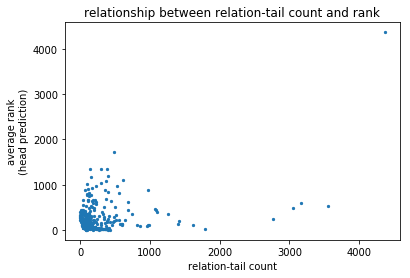

defaultdict(<class 'int'>, {'n:m': 0.41890419737263695, '1:n': 0.11071513423616061, '1:1': 0.34523809523809523, 'n:1': 0.7665289256198347})
{'n:m': 227.0032041012496, '1:n': 983.9080541696364, 'n:1': 238.55578512396696, '1:1': 608.8809523809524}


In [10]:
# analyse prediction_table_head.pkl
# plot relationship between relation-tail count and rank
rel_tail_count_to_avg_rank = dict()
relation_type_to_avg_rank = dict()  # keys: 1:1, 1:n, n:1, n:m
relation_type_to_hits10 = defaultdict(int)
relation_type_count = defaultdict(int)

for index, row in prediction_table_h.iterrows():
    relation_type = relation2type[row['p']]
    if row['rank'] <= 10:
        relation_type_to_hits10[relation_type] += 1
    relation_type_count[relation_type] += 1
        
    if relation_type not in relation_type_to_avg_rank:
        relation_type_to_avg_rank[relation_type] = (row['rank'], 1)
    else:
        relation_type_to_avg_rank[relation_type] = (relation_type_to_avg_rank[relation_type][0] +
                                                   row['rank'],
                                                   relation_type_to_avg_rank[relation_type][1] + 1)

    count_left = head_rel_count[(row['s'], row['p'])]
    count_right = rel_tail_count[(row['p'], row['o'])]
    if count_right not in rel_tail_count_to_avg_rank:
        rel_tail_count_to_avg_rank[count_right] = (row['rank'], 1)
    else:
        rel_tail_count_to_avg_rank[count_right] = (rel_tail_count_to_avg_rank[count_right][0] +
                                                   row['rank'],
                                                   rel_tail_count_to_avg_rank[count_right][1] + 1)

values_sum = sum(relation_type_count.values())
relation_type_to_proportion = {relation_type: round(count / values_sum, 3)
                               for relation_type, count in relation_type_count.items()}
print('proportion of relation types: ' + str(relation_type_to_proportion))

labels = sorted(relation_type_count, key=relation_type_count.get, reverse=True)
sizes = [relation_type_count[label] for label in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, shadow=False, startangle=90)
ax1.axis('equal')
plt.title('proportion of relation types\n')
plt.show()

for relation_type in relation_type_to_hits10:
    relation_type_to_hits10[relation_type] = relation_type_to_hits10[relation_type] \
                                             / relation_type_count[relation_type]

x = []
y = []
for relation_type in sorted(relation_type_to_hits10, key=relation_type_to_hits10.get, reverse=True):
    x.append(relation_type)
    y.append(relation_type_to_hits10[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('hits@10 per relation type')
plt.xlabel('relation type')
plt.ylabel('hits@10\n(head prediction)')
plt.show()
print()

for relation_type, (sum_rank, num) in relation_type_to_avg_rank.items():
    relation_type_to_avg_rank[relation_type] = sum_rank / num

x = []
y = []
for relation_type in sorted(relation_type_to_avg_rank, key=relation_type_to_avg_rank.get):
    x.append(relation_type)
    y.append(relation_type_to_avg_rank[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('average rank per relation type')
plt.xlabel('relation type')
plt.ylabel('average rank\n(head prediction)')
plt.show()

print('Hint: higher is better for hits@10, lower is better for the average rank\n')

for count, (sum_rank, num) in rel_tail_count_to_avg_rank.items():
    rel_tail_count_to_avg_rank[count] = sum_rank / num

x = []
y = []
for count in sorted(rel_tail_count_to_avg_rank):
    x.append(count)
    y.append(rel_tail_count_to_avg_rank[count])
    
plt.figure()
plt.title('relationship between relation-tail count and rank')
plt.xlabel('relation-tail count')
plt.ylabel('average rank\n(head prediction)')
plt.scatter(x, y, s=5)
plt.show()

print(relation_type_to_hits10)
print(relation_type_to_avg_rank)

In [11]:
# analyse prediction_table_head.pkl
# when is the models ranking bad? is there specific a pattern?
mask = prediction_table_h['rank'] > int(14541/2)  # 14541 = num diff. entities
prediction_table_bad = prediction_table_h[mask]
print('There are {} very bad head predictions:'.format(prediction_table_bad.shape[0]))
print('Hint: the numbers stand for a property of the corresponding triple (see more below)\n')

error_id_count = defaultdict(int)
triples_count = 0
rel_tail_counts_bad = set()
for index, row in prediction_table_bad.iterrows():
    rel_tail_counts_bad.add(rel_tail_count[(row[1], row[2])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]

    head_id = torch.tensor([row[0]]).cuda()
    relation_id = torch.tensor([row[1]]).cuda()
    tail_id = torch.tensor([row[2]]).cuda()
    scores_subject = model.predict_subject_scores(head_id, relation_id, tail_id)
    argsort_subject = torch.argsort(scores_subject, dim=1, descending=True)
    models_top10 = []
    for entity_id in argsort_subject[0][:10]:
        try:
            entity_name = mid2name[id2entity[entity_id.item()]]
            models_top10.append(entity_name)
        except:  # entity unknown
            pass
            
    # rank_subject = (argsort_subject == head_id).nonzero()
    # rank_subject = 1 + rank_subject[0][1].item()
    # assert rank_subject == row[3]

    try:
        mid2name[tail]
        print('\ncorrect head: ' + mid2name[head])
        print('given relation: ' + relation)
        print('given tail: ' + mid2name[tail])
        print('instead of the correct entity these entities got a high score:\n')
        error_type_table = pd.DataFrame(columns=['entity name']+[i for i in range(8)])
        for entity_name in models_top10:
            try: 
                triple = (mid2name[head], relation, mid2name[tail])
                error_type = get_error_type(triple, predicted=entity_name, mode='head')
                row_dict = {'entity name': entity_name}
                row_dict.update({error_id: 'x' for error_id in error_type})
                error_type_table = error_type_table.append(row_dict, ignore_index=True)
                for error_id in error_type:
                    error_id_count[error_id] += 1
                triples_count += 1
            except Exception as e:
                print(e)
        print(error_type_table.fillna('').to_string(index=False))
        print()
    except:  # entity unknown
        pass

print('\n\ndescription for every error_id: ' + str(error_id2description_head))

error_id2percentage = {error_id: round(error_id_count[error_id] / triples_count, 3)
                       for error_id in error_id_count}
error_id2percentage = sorted(error_id2percentage.items())
print('\npercentage of very bad head predictions with the corresponding error_id: ' + str(error_id2percentage))

avg_rel_tail_count_bad = sum(rel_tail_counts_bad) / len(rel_tail_counts_bad)
print('\naverage relation-tail count for these very bad head predictions: ' + str(avg_rel_tail_count_bad))

There are 180 very bad head predictions:
Hint: the numbers stand for a property of the corresponding triple (see more below)


correct head: Gene Reynolds
given relation: /film/actor/film./film/performance/film
given tail: The Country Girl
instead of the correct entity these entities got a high score:

      entity name 0 1 2 3  4  5 6 7
    George Seaton          x       
    James Stewart             x    
  Roland Anderson          x       
   Audrey Hepburn             x    
      Hal Pereira          x       
       Lois Smith             x    
     Gregory Peck             x    
  Samuel M. Comer          x       
    Patricia Neal             x    
 Alfred Hitchcock             x    


correct head: Demi Lovato
given relation: /people/person/place_of_birth
given tail: Albuquerque
instead of the correct entity these entities got a high score:

              entity name 0 1  2  3  4  5  6 7
        Bernalillo County            x     x  
              Albuquerque      x     x     x

          entity name 0 1 2 3  4 5  6 7
                 Bono          x    x  
 Jonathan Rhys Meyers          x       
        Keith Andrews          x       
      Brendan Gleeson          x       
          Liam Neeson          x       
        Gabriel Byrne          x       
  George Bernard Shaw          x       
          Stephen Rea          x       
              Ireland          x    x  
           Thin Lizzy          x       


correct head: Joan Crawford
given relation: /film/film_subject/films
given tail: Mommie Dearest
instead of the correct entity these entities got a high score:

        entity name 0 1 2 3 4  5  6 7
     Sicilian Mafia            x     
                law            x  x  
             prison            x  x  
            tragedy            x  x  
           Cold War            x  x  
           aviation            x  x  
             racism            x  x  
       World War II            x  x  
 capital punishment            x  x  
           feminis

                                   entity name 0 1 2  3  4  5  6 7
                                   disc jockey        x  x  x  x  
                               industrial rock           x     x  
                              alternative rock           x     x  
                                        grunge           x     x  
                                        Swedes        x  x  x  x  
 MTV Video Music Award for Best Visual Effects           x     x  
                                  photographer        x  x  x  x  
                                       Koreans        x  x  x  x  
                                 electro house              x  x  
                                   post-grunge           x     x  


correct head: CeeLo Green
given relation: /film/actor/film./film/performance/film
given tail: Hotel Transylvania
instead of the correct entity these entities got a high score:

      entity name 0 1 2 3 4  5 6 7
    Robert Smigel            x    
     Adam Sand

       entity name 0 1  2  3  4  5  6 7
   Anthony Edwards               x     
                ER      x  x  x  x  x  
    Allison Janney               x     
     Maura Tierney         x  x  x     
 Stockard Channing               x     
    George Clooney               x     
       Alex Graves               x     
       Walon Green                     
 Charles S. Dutton               x     
    Shirley Knight               x     


correct head: Walt Disney
given relation: /people/person/places_lived./people/place_lived/location
given tail: France
instead of the correct entity these entities got a high score:

          entity name 0 1 2 3  4  5 6 7
       Roman Polanski          x       
    Alexandre Desplat          x       
      Viggo Mortensen             x    
    Donald Sutherland             x    
      Lorenzo Ferrero                  
        Jeanne Moreau          x       
          Colin Firth             x    
     Isabelle Huppert          x       
 Kristin Scott T

             entity name 0 1 2 3  4  5  6  7
      Barcelona Province          x     x   
                Voltaire             x  x   
           Sigmund Freud             x     x
         Lars Hirschfeld             x      
 Hans Christian Anderson             x  x   
   Jean-Jacques Rousseau             x      
          Samuel Beckett             x      
          Felix Bastians             x      
          Gilles Deleuze             x     x
        Bertrand Russell             x      


correct head: Cedric Gibbons
given relation: /people/person/place_of_birth
given tail: Dublin
instead of the correct entity these entities got a high score:

            entity name 0 1 2  3  4  5  6 7
            Stephen Rea                    
            Liam Neeson           x        
          Gabriel Byrne           x        
       Larry Mullen Jr.           x     x  
           Jim Sheridan           x        
       Jonathan Walters        x  x  x     
 Trinity College Dublin           x  

           entity name 0 1 2  3  4  5  6 7
         French people           x     x  
          Frankenstein              x  x  
                 Ghost        x  x  x  x  
                Hamlet              x  x  
                 Paris        x  x  x  x  
     Death on the Nile              x  x  
              The Firm              x  x  
               Orlando        x  x  x  x  
 Jean-Jacques Rousseau        x  x  x  x  
           The Tourist        x  x  x  x  


correct head: Sarah Jessica Parker
given relation: /people/person/places_lived./people/place_lived/location
given tail: Cincinnati
instead of the correct entity these entities got a high score:

        entity name 0 1 2  3  4  5  6 7
          Doris Day                    
    Hamilton County           x     x  
       James Levine           x        
 Thomas Alva Edison              x     
       Alan Burnett        x  x  x     
            Al Gore              x     
        Jack Warner              x     
   David H

       entity name 0 1 2 3 4  5 6 7
       Bill Paxton            x    
    Robin Williams            x    
        Dan Hedaya            x    
      Gene Hackman            x    
  Cuba Gooding Jr.            x    
 Leonardo DiCaprio            x    
       Kathy Bates            x    
       Brad Dourif            x    
    Jack Nicholson            x    
       Hank Azaria            x    


correct head: David Lynch
given relation: /people/person/religion
given tail: Presbyterianism
instead of the correct entity these entities got a high score:

               entity name 0 1 2 3 4  5 6 7
              Bill Clinton            x    
            George W. Bush            x    
           Harry S. Truman            x    
         Robert F. Kennedy            x    
               John McCain            x    
           John C. Calhoun            x    
     Arnold Schwarzenegger            x    
              Jimmy Carter            x    
 Franklin Delano Roosevelt            x    
    

In [12]:
# analyse prediction_table_head.pkl
# when is the models ranking good? is there specific a pattern?
mask = prediction_table_h['rank'] == 1
prediction_table_perfect_h = prediction_table_h[mask]
print('There are {} perfect head predictions:\n'.format(prediction_table_perfect_h.shape[0]))

rel_tail_counts_good = set()
for index, row in prediction_table_perfect_h.iterrows():
    rel_tail_counts_good.add(rel_tail_count[(row[1], row[2])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]
    try:
        mid2name[tail]
        print(mid2name[head])
        print(relation)
        print(mid2name[tail])
        print()
    except:  # entity unknown
        pass

avg_rel_tail_count_good = sum(rel_tail_counts_good) / len(rel_tail_counts_good)
print('average relation-tail count for these good head predictions: ' + str(avg_rel_tail_count_good))

There are 2660 perfect head predictions:

Zürich
/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
October

England
/location/location/contains
Pontefract

England
/location/location/contains
Lancaster

prime minister
/government/government_office_category/officeholders./government/government_position_held/jurisdiction_of_office
Liechtenstein

2008 Summer Olympics
/olympics/olympic_games/participating_countries
Djibouti

2008 Summer Olympics
/olympics/olympic_games/participating_countries
Mauritania

Virginia
/location/statistical_region/religions./location/religion_percentage/religion
Presbyterianism

Grammy Award for Best Country Album
/award/award_category/winners./award/award_honor/ceremony
2000 Grammy Awards

Los Angeles Rams
/sports/sports_team/sport
American football

African Americans
/people/ethnicity/people
John Lee Hooker

Belgium
/organization/organization_member/member_of./organization/organization_membership/organization
League of Nations


Eritrea
/base/aareas/schema/administrative_area/administrative_parent
Earth

38th People's Choice Awards
/award/award_ceremony/awards_presented./award/award_honor/award_winner
Katy Perry

Screen Actors Guild Award for Outstanding Performance by a Female Actor in a Supporting Role
/award/award_category/winners./award/award_honor/ceremony
15th Screen Actors Guild Awards

Epic Records
/music/record_label/artist
Steve Vai

Toni Collette
/people/person/profession
actor

64th Primetime Emmy Awards
/award/award_ceremony/awards_presented./award/award_honor/award_winner
Jon Stewart

Primetime Emmy Award for Outstanding Drama Series
/award/award_category/winners./award/award_honor/ceremony
61st Primetime Emmy Awards

pop rock
/music/genre/artists
Jesse McCartney

Magic Knight Rayearth
/tv/tv_program/genre
anime

bass guitar
/music/performance_role/regular_performances./music/group_membership/group
Danzig

Broadcast Film Critics Association Award for Best Cast
/award/award_category/winners./awar

Johannes Brahms

World War II
/time/event/locations
Europe

Juris Doctor
/education/educational_degree/people_with_this_degree./education/education/institution
Columbia University

opera
/music/genre/artists
Nikolai Rimsky-Korsakov

1912 Summer Olympics
/olympics/olympic_games/medals_awarded./olympics/olympic_medal_honor/medal
gold medal

16th Screen Actors Guild Awards
/award/award_ceremony/awards_presented./award/award_honor/award_winner
Vincent Kartheiser

diploma
/education/educational_degree/people_with_this_degree./education/education/major_field_of_study
international relations

Rock and Roll Hall of Fame
/award/hall_of_fame/inductees./award/hall_of_fame_induction/inductee
ZZ Top

Anne Hathaway
/people/person/gender
female organism

artistic gymnastics
/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country
Canada

Annie Hall
/award/award_winning_work/awards_won./award/award_honor/award
New York Film Critics Circle Award for Best Actress

Polydor Records
/

1968 Winter Olympics

Golden Raspberry Award for Worst Supporting Actor
/award/award_category/nominees./award/award_nomination/nominated_for
Superman III

T. S. Eliot
/people/person/profession
playwright

Grammy Award for Best Music Film
/award/award_category/winners./award/award_honor/ceremony
51st Annual Grammy Awards

Nepal
/organization/organization_member/member_of./organization/organization_membership/organization
United Nations

Sudan
/organization/organization_member/member_of./organization/organization_membership/organization
United Nations

jazz fusion
/music/genre/artists
Tony Levin

United Kingdom
/location/location/contains
Chelsea

Primetime Emmy Award for Outstanding Comedy-Variety Or Music Program
/award/award_category/winners./award/award_honor/ceremony
59th Primetime Emmy Awards

Broadcast Film Critics Association Award for Best Cast
/award/award_category/winners./award/award_honor/award_winner
Diane Kruger

California
/location/location/contains
Visalia

broccoli
/fo

India

Academy Award for Best Animated Short Film
/award/award_category/winners./award/award_honor/ceremony
36th Academy Awards

Pirates of the Caribbean: The Curse of the Black Pearl
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Finland

University of Southern California
/education/educational_institution/students_graduates./education/education/student
Basil Poledouris

Malayali
/people/ethnicity/geographic_distribution
Kuwait

1896 Denizli Olimpiyatları
/olympics/olympic_games/medals_awarded./olympics/olympic_medal_honor/medal
gold medal

University College London
/education/educational_institution/students_graduates./education/education/major_field_of_study
English literature

Screen Actors Guild Award for Outstanding Performance by a Cast in a Motion Picture
/award/award_category/nominees./award/award_nomination/nominated_for
Sideways

Laura Dern
/people/person/profession
actor

television
/media_common/netflix_genre/titles
Arrested Development

63r

/media_common/netflix_genre/titles
The King's Speech

alternative hip hop
/music/genre/artists
Tricky Stewart

St. John's University
/organization/non_profit_organization/registered_with./organization/non_profit_registration/registering_agency
Internal Revenue Service

Piper Laurie
/people/person/profession
actor

pork
/food/food/nutrients./food/nutrition_fact/nutrient
L-Arginine

Pyrus
/food/food/nutrients./food/nutrition_fact/nutrient
glucose

Munich
/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
June

35th Canadian Parliament
/government/legislative_session/members./government/government_position_held/district_represented
Northwest Territories

drum kit
/music/performance_role/regular_performances./music/group_membership/group
Panic! at the Disco

television
/media_common/netflix_genre/titles
Grey's Anatomy

theater
/education/field_of_study/students_majoring./education/education/student
Loretta Devine

Golden State Warriors
/sports/professional_

In [13]:
# load prediction_table_tail.pkl
path = os.path.join(model_output_path, 'prediction_table_tail.pkl')
prediction_table_tail = pd.read_pickle(path)
prediction_table_tail['rank of true tail'] = pd.to_numeric(prediction_table_tail['rank of true tail'],
                                                           downcast='integer')

s = []
p = []
o = []
topics = []
for _, triple_str in prediction_table_tail['triple'].iteritems():
    triple = re.split(',', triple_str[1:-1])
    s.append(int(triple[0].strip()))
    p.append(int(triple[1].strip()))
    o.append(int(triple[2].strip()))
    topics.append(id2relation[int(triple[1].strip())].split('/')[1])

prediction_table_t = pd.DataFrame(columns=['s', 'p', 'o', 'rank'])
prediction_table_t['s'] = s
prediction_table_t['p'] = p
prediction_table_t['o'] = o
prediction_table_t['rank'] = prediction_table_tail['rank of true tail']
prediction_table_t['topic'] = topics

easy relations for tail prediction (10 relations with the lowest average rank):

/tv/tv_personality/tv_regular_appearances./tv/tv_regular_personal_appearance/program
/award/ranked_item/appears_in_ranked_lists./award/ranking/list
/baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
/business/business_operation/industry
/education/educational_institution/students_graduates./education/education/student
/education/educational_institution_campus/educational_institution
/sports/sports_team/roster./american_football/football_historical_roster_position/position_s
/film/film/release_date_s./film/film_regional_release_date/film_release_region
/sports/sports_team/sport
/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film



difficult relations for tail prediction (10 relations with the highest average rank):

/sports/sports_team_location/teams
/business/business_operation/operating_income./measurement_unit/dated_money_value/currency
/people/mar

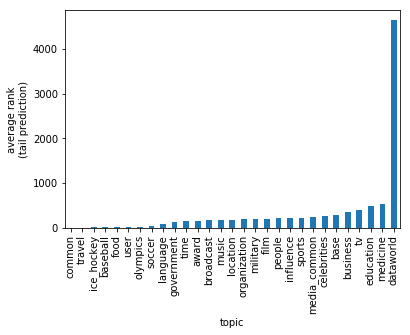

examples for "easy" topics:

example for topic common: /common/topic/webpage./common/webpage/category
example for topic travel: /travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
example for topic ice_hockey: /ice_hockey/hockey_team/current_roster./sports/sports_team_roster/position
example for topic baseball: /baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
example for topic food: /food/food/nutrients./food/nutrition_fact/nutrient


examples for "difficult" topics:

example for topic business: /business/job_title/people_with_this_title./business/employment_tenure/company
example for topic tv: /tv/tv_program/regular_cast./tv/regular_tv_appearance/actor
example for topic education: /education/field_of_study/students_majoring./education/education/student
example for topic medicine: /medicine/disease/notable_people_with_this_condition
example for topic dataworld: /dataworld/gardening_hint/split_to


In [14]:
# analyse prediction_table_tail.pkl
# find "easy" relations (relations that are part of triples with a good rank) and "difficult" relations

print('easy relations for tail prediction (10 relations with the lowest average rank):\n')
for row in prediction_table_t[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank').head(10).iterrows():
    print(id2relation[row[0]])

print('\n\n\ndifficult relations for tail prediction (10 relations with the highest average rank):\n')
for row in prediction_table_t[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank', ascending=False).head(10).iterrows():
    print(id2relation[row[0]])
    
print('\n\n\naverage rank of each topic (tail prediction:')
df = prediction_table_t[['topic', 'rank']].groupby('topic', as_index=False)['rank'].mean().\
                                           sort_values(by='rank')
ax = df.plot.bar(x='topic', y='rank', rot=90, legend=False).set_ylabel('average rank\n(tail prediction)')
plt.show()

# find examples for the "easy" topics
print('examples for "easy" topics:\n')
for index, topic in df.head(5)['topic'].iteritems():
    for index, row in prediction_table_t[['p', 'rank', 'topic']].sort_values(by='rank')[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

# find examples for the "difficult" topics
print('\n\nexamples for "difficult" topics:\n')
for index, topic in df.tail(5)['topic'].iteritems():
    for index, row in prediction_table_t[['p', 'rank', 'topic']].sort_values(by='rank', ascending=False)[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

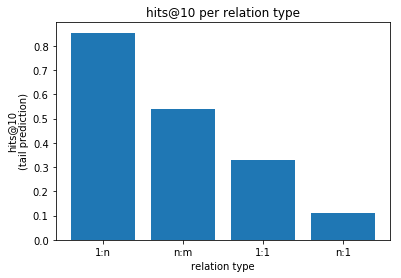

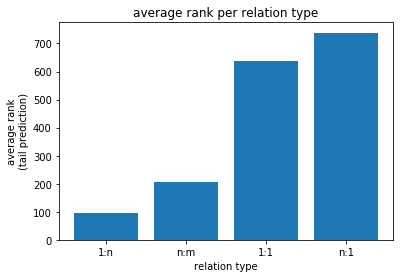

Hint: higher is better for hits@10, lower is better for the average rank



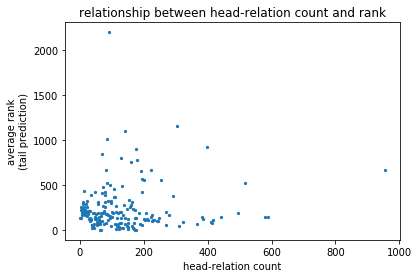

defaultdict(<class 'int'>, {'n:m': 0.5409804549823775, '1:n': 0.8541221192682348, '1:1': 0.3273809523809524, 'n:1': 0.10950413223140495})
{'n:m': 204.59423261775072, '1:n': 96.66025184129246, 'n:1': 738.3657024793389, '1:1': 638.0416666666666}


In [15]:
# analyse prediction_table_tail.pkl
# plot relationship between head-relation count and rank
head_rel_count_to_avg_rank = dict()
relation_type_to_avg_rank = dict()
relation_type_to_hits10 = defaultdict(int)
relation_type_count = defaultdict(int)

for index, row in prediction_table_t.iterrows():
    relation_type = relation2type[row['p']]
    if row['rank'] <= 10:
        relation_type_to_hits10[relation_type] += 1
    relation_type_count[relation_type] += 1

    if relation_type not in relation_type_to_avg_rank:
        relation_type_to_avg_rank[relation_type] = (row['rank'], 1)
    else:
        relation_type_to_avg_rank[relation_type] = (relation_type_to_avg_rank[relation_type][0] +
                                                    row['rank'],
                                                    relation_type_to_avg_rank[relation_type][1] + 1)

    count_left = head_rel_count[(row['s'], row['p'])]
    count_right = rel_tail_count[(row['p'], row['o'])]
    if count_left not in head_rel_count_to_avg_rank:
        head_rel_count_to_avg_rank[count_left] = (row['rank'], 1)
    else:
        head_rel_count_to_avg_rank[count_left] = (head_rel_count_to_avg_rank[count_left][0] +
                                                  row['rank'],
                                                  head_rel_count_to_avg_rank[count_left][1] + 1)

for relation_type in relation_type_to_hits10:
    relation_type_to_hits10[relation_type] = relation_type_to_hits10[relation_type] \
                                             / relation_type_count[relation_type]

x = []
y = []
for relation_type in sorted(relation_type_to_hits10, key=relation_type_to_hits10.get, reverse=True):
    x.append(relation_type)
    y.append(relation_type_to_hits10[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('hits@10 per relation type')
plt.xlabel('relation type')
plt.ylabel('hits@10\n(tail prediction)')
plt.show()
print()

for relation_type, (sum_rank, num) in relation_type_to_avg_rank.items():
    relation_type_to_avg_rank[relation_type] = sum_rank / num

x = []
y = []
for relation_type in sorted(relation_type_to_avg_rank, key=relation_type_to_avg_rank.get):
    x.append(relation_type)
    y.append(relation_type_to_avg_rank[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('average rank per relation type')
plt.xlabel('relation type')
plt.ylabel('average rank\n(tail prediction)')
plt.show()

print('Hint: higher is better for hits@10, lower is better for the average rank\n')

for count, (sum_avg_rank, num) in head_rel_count_to_avg_rank.items():
    head_rel_count_to_avg_rank[count] = sum_avg_rank / num

x = []
y = []
for count in sorted(head_rel_count_to_avg_rank):
    x.append(count)
    y.append(head_rel_count_to_avg_rank[count])
    
plt.figure()
plt.title('relationship between head-relation count and rank')
plt.xlabel('head-relation count')
plt.ylabel('average rank\n(tail prediction)')
plt.scatter(x, y, s=5)
plt.show()

print(relation_type_to_hits10)
print(relation_type_to_avg_rank)

In [16]:
# analyse prediction_table_tail.pkl
# when is the models ranking bad? is there specific a pattern?
mask = prediction_table_t['rank'] > int(14541/2)  # 14541 = num diff. entities
prediction_table_bad = prediction_table_t[mask]
print('There are {} very bad tail predictions:'.format(prediction_table_bad.shape[0]))
print('Hint: the numbers stand for a property of the corresponding triple (see more below)\n')

error_id_count = defaultdict(int)
triples_count = 0
head_rel_counts_bad = set()
for index, row in prediction_table_bad.iterrows():
    head_rel_counts_bad.add(head_rel_count[(row[0], row[1])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]

    head_id = torch.tensor([row[0]]).cuda()
    relation_id = torch.tensor([row[1]]).cuda()
    tail_id = torch.tensor([row[2]]).cuda()
    scores_object = model.predict_object_scores(head_id, relation_id, tail_id)
    argsort_object = torch.argsort(scores_object, dim=1, descending=True)
    models_top10 = []
    for entity_id in argsort_object[0][:10]:
        try:
            entity_name = mid2name[id2entity[entity_id.item()]]
            models_top10.append(entity_name)
        except:  # entity unknown
            pass
        
    # rank_object = (argsort_object == tail_id).nonzero()
    # rank_object = 1 + rank_object[0][1].item()
    # assert rank_object == row[3]

    try:
        mid2name[tail]
        print('\ngiven head: ' + mid2name[head])
        print('given relation: ' + relation)
        print('correct tail: ' + mid2name[tail])
        print('instead of the correct entity these entities got a high score: ')
        error_type_table = pd.DataFrame(columns=['entity name']+[i for i in range(8)])
        for entity_name in models_top10:
            try: 
                triple = (mid2name[head], relation, mid2name[tail])
                error_type = get_error_type(triple, predicted=entity_name, mode='tail')
                row_dict = {'entity name': entity_name}
                row_dict.update({error_id: 'x' for error_id in error_type})
                error_type_table = error_type_table.append(row_dict, ignore_index=True)
                for error_id in error_type:
                    error_id_count[error_id] += 1
                triples_count += 1
            except Exception as e:
                print(e)
        print(error_type_table.fillna('').to_string(index=False))
        print()
    except:  # entity unknown
        pass

print('\n\ndescription for every error_id: ' + str(error_id2description_tail))
error_id2percentage = {error_id: round(error_id_count[error_id] / triples_count, 3)
                       for error_id in error_id_count}
error_id2percentage = sorted(error_id2percentage.items())
print('\npercentage of very bad tail predictions with the corresponding error_id: ' + str(error_id2percentage))

avg_head_rel_count_bad = sum(head_rel_counts_bad) / len(head_rel_counts_bad)
print('\naverage head-relation count for these very bad tail predictions: ' + str(avg_head_rel_count_bad))

There are 74 very bad tail predictions:
Hint: the numbers stand for a property of the corresponding triple (see more below)


given head: Lesser Antilles
given relation: /location/location/partially_contains
correct tail: Netherlands
instead of the correct entity these entities got a high score: 
           entity name 0 1 2 3  4  5  6 7
 Appalachian Mountains             x  x  
        Missouri River             x     
         Cascade Range             x  x  
  Adirondack Mountains             x  x  
             Himalayas             x  x  
     Mississippi River             x  x  
                 Andes             x  x  
                Danube             x  x  
              Barbados          x        
                  Alps             x  x  


given head: Patrick Stewart
given relation: /influence/influence_node/influenced_by
correct tail: Laurence Olivier
instead of the correct entity these entities got a high score: 
            entity name 0 1 2 3 4  5 6 7
          George O

                                       entity name 0 1 2  3  4  5  6 7
                                          Showtime        x  x  x  x  
                                     Ben Silverman        x  x  x     
 Primetime Emmy Award for Outstanding Original ...           x        
 Primetime Emmy Award for Outstanding Costumes ...           x        
                                   Brendan Gleeson        x  x  x     
                                Michael Fassbender              x     
                               Callum Keith Rennie              x     
                                         Alan Dale              x     
                                      John Lithgow              x     
                                      Leslie Caron        x  x  x     


given head: Rutger Hauer
given relation: /film/actor/film./film/performance/film
correct tail: Confessions of a Dangerous Mind
instead of the correct entity these entities got a high score: 
                  entity n

   entity name 0 1 2  3  4  5  6 7
   Los Angeles              x  x  
        Malibu              x  x  
 Beverly Hills              x  x  
     Las Vegas              x  x  
      Brooklyn              x  x  
        Boston              x  x  
       Chicago        x  x  x  x  
  Philadelphia              x  x  
      Evanston              x  x  
       Memphis              x  x  


given head: 2012
given relation: /film/film/produced_by
correct tail: Vince Vaughn
instead of the correct entity these entities got a high score: 
       entity name 0 1 2 3 4  5 6 7
   Roland Emmerich                 
    Neal H. Moritz            x    
   Lawrence Gordon            x    
     Laurence Mark            x    
       Joel Silver            x    
        Ron Howard            x    
       Scott Rudin            x    
 Jerry Bruckheimer            x    
        John Davis            x    
       Walter Hill            x    


given head: Jason Schwartzman
given relation: /base/popstra/celebrit

   entity name 0 1 2 3 4  5 6 7
 James Stewart            x    
  Rex Harrison            x    
    Jack Benny            x    
  George Burns            x    
  Pinto Colvig            x    
   Miles Davis            x    
     Alan Ladd            x    
    Glenn Ford            x    
   Dom DeLuise            x    
    John Wayne            x    


given head: economics
given relation: /education/field_of_study/students_majoring./education/education/student
correct tail: Cate Blanchett
instead of the correct entity these entities got a high score: 
              entity name 0 1 2  3  4  5 6 7
           Woodrow Wilson              x    
             Bill Clinton        x  x  x    
                 Kal Penn              x    
               Niels Bohr              x    
 William Pitt the Younger              x    
              Dick Cheney              x    
            Richard Nixon        x  x  x    
          Richard Dawkins              x    
             Gordon Brown            

                      entity name 0  1  2 3 4  5  6 7
                     Pennsylvania    x  x      x  x  
                     Philadelphia              x  x  
                     Wilkes-Barre              x  x  
                        Cleveland              x  x  
 Carnegie Institute of Technology              x  x  
                         Delaware                 x  
                  Pratt Institute              x  x  
         Johns Hopkins University              x  x  
                        Rockville              x  x  
                      Kent County              x  x  


given head: School of the Art Institute of Chicago
given relation: /education/educational_institution/students_graduates./education/education/student
correct tail: Orson Welles
instead of the correct entity these entities got a high score: 
                            entity name 0 1  2  3  4  5  6 7
                            Red Skelton         x  x  x     
                     Christopher Walken  

         entity name 0 1 2 3 4  5  6 7
 Suicidal Tendencies            x  x  
          Dave Grohl            x     
         Limp Bizkit            x     
          Rob Zombie            x     
    Jane's Addiction            x     
         Sonic Youth            x  x  
       Henry Rollins            x     
           Morrissey            x  x  
           Sepultura            x  x  
        Billy Corgan            x     


given head: African Americans
given relation: /people/ethnicity/people
correct tail: Nicole Richie
instead of the correct entity these entities got a high score: 
    entity name 0 1 2  3  4  5  6 7
        Fat Joe        x  x  x     
   Robin Thicke              x     
           P!nk              x  x  
        Lil Jon        x  x  x     
 Jennifer Lopez              x     
      LL Cool J        x  x  x  x  
    Clive Davis              x     
    Carl Reiner              x     
 Jane Krakowski        x  x  x     
  Yolanda Adams        x  x  x     


given he

   entity name 0 1 2  3  4  5  6 7
        Canada                 x  
       Finland              x  x  
   British Raj              x     
 North Vietnam              x  x  
        Norway              x  x  
    Yugoslavia              x  x  
        Taiwan              x  x  
       Denmark              x  x  
        Brazil        x  x  x  x  
   Switzerland        x  x  x  x  



description for every error_id: {0: 'predicted tail is actually correct', 1: 'predicted tail is similar to true tail, but not the same', 2: 'predicted tail = given head', 3: 'predicted tail neither occured together with given relation nor with given head', 4: 'predicted tail and given relation never occured together', 5: 'predicted tail and given head never occured together', 6: 'wrong named entity type', 7: 'predicted tail has correct named entity type and occured with the given relation'}

percentage of very bad tail predictions with the corresponding error_id: [(1, 0.001), (2, 0.021), (3, 0.158), (4, 0

In [17]:
# analyse prediction_table_tail.pkl
# when is the models ranking good? is there specific a pattern?
mask = prediction_table_t['rank'] == 1
prediction_table_perfect_t = prediction_table_t[mask]
print('There are {} perfect tail predictions:\n'.format(prediction_table_perfect_t.shape[0]))

head_rel_counts_good = set()
for index, row in prediction_table_perfect_t.iterrows():
    head_rel_counts_good.add(head_rel_count[(row[0], row[1])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]
    try:
        mid2name[tail]
        print(mid2name[head])
        print(relation)
        print(mid2name[tail])
        print()
    except:  # entity unknown
        pass

avg_head_rel_count_good = sum(head_rel_counts_good) / len(head_rel_counts_good)
print('average head-relation count for these good tail predictions: ' + str(avg_head_rel_count_good))

There are 6375 perfect tail predictions:

Zürich
/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
October

Asheville
/location/location/time_zones
Eastern Time Zone

Lycoming County
/location/statistical_region/rent50_2./measurement_unit/dated_money_value/currency
United States dollar

Virginia
/location/statistical_region/religions./location/religion_percentage/religion
Presbyterianism

Grammy Award for Best Country Album
/award/award_category/winners./award/award_honor/ceremony
2000 Grammy Awards

Christianity
/user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy
Library of Congress Classification

Tom Werner
/tv/tv_producer/programs_produced./tv/tv_producer_term/producer_type
executive producer

The Beaver
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Brazil

Los Angeles Rams
/sports/sports_team/sport
American football

Lincoln
/film/film/estimated_budget./measurement_unit/dated_

Salmon Fishing in the Yemen
/film/film/language
English

Mike Myers
/people/person/spouse_s./people/marriage/type_of_union
marriage

James Stewart
/people/person/gender
male organism

Saw
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Finland

Click
/film/film/other_crew./film/film_crew_gig/film_crew_role
visual effects supervisor

Vassar College
/education/educational_institution/campuses
Vassar College

Mexico
/olympics/olympic_participating_country/medals_won./olympics/olympic_medal_honor/medal
gold medal

Christopher Columbus
/user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy
Library of Congress Classification

Togo
/location/location/time_zones
Greenwich Mean Time

Family Guy
/tv/tv_program/genre
animated film

Andrew Lau
/people/person/profession
film director

Portland
/location/hud_county_place/place
Portland

Charles County
/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/date

/film/film/other_crew./film/film_crew_gig/film_crew_role
visual effects supervisor

Bullets Over Broadway
/film/film/genre
comedy

Robert Zemeckis
/base/schemastaging/person_extra/net_worth./measurement_unit/dated_money_value/currency
United States dollar

Marcia Wallace
/people/person/nationality
United States of America

The Last King of Scotland
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

Hugo Friedhofer
/people/person/nationality
United States of America

Corey Feldman
/people/person/gender
male organism

Jayma Mays
/people/person/gender
female organism

In the Mood for Love
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Germany

Carl Foreman
/people/person/profession
film director

Naval Postgraduate School
/organization/endowed_organization/endowment./measurement_unit/dated_money_value/currency
United States dollar

The Bridge on the River Kwai
/award/award_winning_work/awards_won./award/award_ho

/people/person/spouse_s./people/marriage/type_of_union
domestic partnership

John Malkovich
/people/person/profession
film director

Richmond
/location/location/time_zones
Eastern Time Zone

Getafe CF
/sports/sports_team/sport
association football

The Guard
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Sweden

The A-Team
/film/film/other_crew./film/film_crew_gig/film_crew_role
production sound mixer

Portsmouth
/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/dated_integer/source
United States Department of Housing and Urban Development

Dave Goelz
/people/person/gender
male organism

Alan Ball
/award/award_nominee/award_nominations./award/award_nomination/award
Writers Guild of America Award for Best Original Screenplay

Dexter
/tv/tv_program/genre
crime novel

Kill Bill Volume 2
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

Persepolis
/film/film/release_date_s./film/film


Hong Kong Film Award for Best Film
/award/award_category/nominees./award/award_nomination/nominated_for
2046

Academy Award for Best Supporting Actress
/award/award_category/winners./award/award_honor/ceremony
24th Academy Awards

Academy Award for Best Supporting Actress
/award/award_category/winners./award/award_honor/ceremony
56th Academy Awards

Jack Black
/people/person/spouse_s./people/marriage/type_of_union
domestic partnership

Danny DeVito
/award/award_nominee/award_nominations./award/award_nomination/award
Golden Raspberry Award for Worst Supporting Actor

T. R. Knight
/people/person/nationality
United States of America

Cris Collinsworth
/people/person/spouse_s./people/marriage/type_of_union
marriage

Grammy Award for Best Contemporary Jazz Album
/award/award_category/winners./award/award_honor/ceremony
1999 Grammy Awards

Blades of Glory
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

The Butterfly Effect
/film/film/estimate


grunge
/music/genre/parent_genre
alternative rock

84th Academy Awards
/time/event/instance_of_recurring_event
Academy Awards

BC Lions
/sports/sports_team/colors
black

David Duchovny
/people/person/gender
male organism

Fish Tank
/film/film/production_companies
UK Film Council

Fish Tank
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

Diana Wynne Jones
/people/person/profession
author

Chris Isaak
/people/person/profession
musician

The Cell
/film/film/release_date_s./film/film_regional_release_date/film_release_region
United States of America

Deep Impact
/film/film/country
United States of America

Grammy Award for Best Male Country Vocal Performance
/award/award_category/winners./award/award_honor/ceremony
2004 Grammy Awards

Juliette Binoche
/award/award_nominee/award_nominations./award/award_nomination/award
Academy Award for Best Actress

The Mummy Returns
/film/film/other_crew./film/film_crew_gig/film_crew_role
make-up artist

Th

marriage

Jacqueline Bisset
/people/person/languages
French

Dimension Films
/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film
Scary Movie

Delroy Lindo
/people/person/spouse_s./people/marriage/type_of_union
marriage

Steve Zahn
/people/person/profession
comedian

Merv Griffin
/people/person/religion
Catholicism

University of Queensland
/award/ranked_item/appears_in_ranked_lists./award/ranking/list
Times Higher Education World University Rankings

James Arness
/people/deceased_person/place_of_burial
Forest Lawn Memorial Park

Malcolm McDowell
/people/person/gender
male organism

Detective Dee and the Mystery of the Phantom Flame
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

The Impossible
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Mexico

Randy Quaid
/people/person/profession
actor

Locus Award for Best Science Fiction Novel
/award/award_category/disciplines_or_s

2012 Summer Olympics

Spain
/base/aareas/schema/administrative_area/administrative_parent
Earth

Meet the Fockers
/film/film/other_crew./film/film_crew_gig/film_crew_role
special effects supervisor

The Avengers
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Philippines

Allium cepa
/food/food/nutrients./food/nutrition_fact/nutrient
L-Arginine

Dr. Dre
/people/person/profession
artist

Texas Rangers
/baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
2000 Major League Baseball season

Abraham Lincoln: Vampire Hunter
/film/film/release_date_s./film/film_regional_release_date/film_release_region
United Kingdom

Enchanted
/film/film/distributors./film/film_film_distributor_relationship/region
United Kingdom

Brian Baumgartner
/base/schemastaging/person_extra/net_worth./measurement_unit/dated_money_value/currency
United States dollar

Moe Howard
/people/person/places_lived./people/place_lived/location
Brooklyn

A.E.K. Athens F.C.
/soccer/

United States dollar

Harry Turtledove
/people/person/religion
Judaism

diving
/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country
United Kingdom

8 Women
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Sweden

Timothy Hutton
/people/person/spouse_s./people/marriage/type_of_union
marriage

Stephen Colbert
/people/person/languages
English

Johnson & Johnson
/base/schemastaging/organization_extra/phone_number./base/schemastaging/phone_sandbox/contact_category
customer service

Oregon
/location/location/partially_contains
Cascade Range

Djimon Hounsou
/award/award_nominee/award_nominations./award/award_nomination/award
Screen Actors Guild Award for Outstanding Performance by a Cast in a Motion Picture

Ray Manzarek
/people/person/nationality
United States of America

Billie Holiday
/people/person/nationality
United States of America

Lost Highway
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Germany

English

Gregory Hoblit
/people/person/spouse_s./people/marriage/type_of_union
marriage

Nixon
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

Dell Inc.
/award/ranked_item/appears_in_ranked_lists./award/ranking/list
Fortune 500

David Cross
/people/person/spouse_s./people/marriage/type_of_union
marriage

111th United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
Mississippi

Ryan Reynolds
/people/person/profession
actor

The Impossible
/film/film/other_crew./film/film_crew_gig/film_crew_role
make-up artist

Gulliver's Travels
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

Edge of Darkness
/film/film/genre
drama film

The Expendables
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Portugal

Guy Ritchie
/people/person/profession
film director

Nagesh
/people/person/profession
actor

110th United S

The Dark Knight
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Kazakhstan

American English
/language/human_language/countries_spoken_in
United States of America

Dark Shadows
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Portugal

Whitney Houston
/people/deceased_person/place_of_death
Beverly Hills

Elizabeth McGovern
/people/person/languages
English

Johannes Brahms
/people/person/profession
composer

Jim Carrey
/base/schemastaging/person_extra/net_worth./measurement_unit/dated_money_value/currency
United States dollar

Chuck Jones
/people/person/profession
television director

Julia Stiles
/award/award_nominee/award_nominations./award/award_nomination/award
Screen Actors Guild Award for Outstanding Performance by an Ensemble in a Drama Series

Ve Neill
/people/person/nationality
United States of America

Rupert Everett
/people/person/gender
male organism

Joni Mitchell
/music/artist/track_contributions./music/track_con

United States of America

cheese
/food/food/nutrients./food/nutrition_fact/nutrient
pantothenic acid

Ricky Nelson
/people/person/profession
actor

Phil Hartman
/film/actor/dubbing_performances./film/dubbing_performance/language
English

(500) Days of Summer
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Hungary

Bob Odenkirk
/people/person/nationality
United States of America

Walter Becker
/people/person/profession
songwriter

St. Clair County
/location/location/time_zones
Central Time Zone

Saint Mary's College of California
/organization/non_profit_organization/registered_with./organization/non_profit_registration/registering_agency
Internal Revenue Service

Matt LeBlanc
/people/person/spouse_s./people/marriage/type_of_union
marriage

Grammy Award for Best Classical Album
/award/award_category/winners./award/award_honor/ceremony
2003 Grammy Awards

The Dark Knight Rises
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Ir

United States dollar

Charlie Chaplin
/award/award_nominee/award_nominations./award/award_nomination/award
Academy Award for Best Picture

George A. Romero
/people/person/nationality
United States of America

Charlie and the Chocolate Factory
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Denmark

He's Just Not That into You
/film/film/other_crew./film/film_crew_gig/film_crew_role
special effects supervisor

Frank R. McKelvy
/award/award_nominee/award_nominations./award/award_nomination/award
Academy Award for Best Production Design

Academy Award for Best Director
/award/award_category/winners./award/award_honor/ceremony
29th Academy Awards

Frankfort
/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/dated_integer/source
United States Department of Housing and Urban Development

Aruna Irani
/people/person/spouse_s./people/marriage/type_of_union
marriage

Peter Stone
/people/person/profession
screenwriter

The Postman
/film/f

public university

The Lord of the Rings: The Fellowship of the Ring
/film/film/film_format
Super 35

Dwight Yoakam
/people/person/profession
singer-songwriter

Samson and Delilah
/film/film/release_date_s./film/film_regional_release_date/film_release_region
United States of America

Sunshine
/film/film/other_crew./film/film_crew_gig/film_crew_role
production sound mixer

Avatar: The Last Airbender
/tv/tv_program/genre
adventure film

Lost Highway
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Hong Kong

Austin Powers in Goldmember
/film/film/film_format
Super 35

John Osborne
/people/person/nationality
England

Chocolat
/film/film/executive_produced_by
Bob Weinstein

Grammy Award for Best Bluegrass Album
/award/award_category/winners./award/award_honor/ceremony
36th Annual Grammy Awards

Christian Slater
/people/person/languages
English

Hong Kong Film Award for Best Director
/award/award_category/nominees./award/award_nomination/nominated_for
Red Cliff

In [18]:
# analyse worst_predictions_head.pkl
path = os.path.join(model_output_path, 'worst_predictions_head.pkl')
worst_predictions_head = pd.read_pickle(path)
worst_predictions_head['rank'] = pd.to_numeric(worst_predictions_head['rank'], downcast='integer')
print(worst_predictions_head.head(10).to_string(index=False))

count_head_entities_worst = dict()
count_relations_worst = dict()
count_tail_entities_worst = dict()

for triple in worst_predictions_head['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_worst[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_worst[relation_id] = count_relations_train[relation_id]
    count_tail_entities_worst[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_worst))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_worst))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_worst))

              triple   rank
 [ 5474   129 13229]  14266
    [8664   96 2070]  13817
 [12424     9 12573]  12913
 [13113    17  8288]  12255
    [5926   96 8092]  12206
 [ 1130   149 10760]  12041
    [1724  156 2321]  11524
    [4824    6 9139]  11439
    [3479   10 4633]  11422
 [10411     7  6325]  11406

number of occurrences of this head entities in the training data (as head): {5474: 55, 8664: 50, 12424: 49, 13113: 38, 5926: 60, 1130: 38, 1724: 46, 4824: 66, 3479: 14, 10411: 39}

number of occurrences of this relations in the training data: {129: 5201, 96: 12893, 9: 12157, 17: 335, 149: 5880, 156: 1327, 6: 2727, 10: 15989, 7: 909}

number of occurrences of this tail entities in the training data (as tail): {13229: 25, 2070: 242, 12573: 107, 8288: 102, 8092: 464, 10760: 17, 2321: 22, 9139: 17, 4633: 9, 6325: 46}


In [19]:
# analyse worst_predictions_tail.pkl
path = os.path.join(model_output_path, 'worst_predictions_tail.pkl')
worst_predictions_tail = pd.read_pickle(path)
worst_predictions_tail['rank'] = pd.to_numeric(worst_predictions_tail['rank'], downcast='integer')

print(worst_predictions_tail.head(10).to_string(index=False))

count_head_entities_worst = dict()
count_relations_worst = dict()
count_tail_entities_worst = dict()

for triple in worst_predictions_tail['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_worst[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_worst[relation_id] = count_relations_train[relation_id]
    count_tail_entities_worst[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_worst))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_worst))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_worst))

              triple   rank
 [ 6206    50 10191]  12615
 [ 1603     9 12031]  12029
 [ 6928   191 11273]  11981
 [ 3378    96 11537]  11841
 [ 3188    89 11337]  11597
 [13414     9 12170]  11287
    [5140  189 5474]  11275
 [12645    96  8514]  10980
 [13613   125 13390]  10865
    [5474   34 2716]  10525

number of occurrences of this head entities in the training data (as head): {6206: 48, 1603: 21, 6928: 14, 3378: 25, 3188: 31, 13414: 102, 5140: 25, 12645: 46, 13613: 5, 5474: 55}

number of occurrences of this relations in the training data: {50: 3612, 9: 12157, 191: 10945, 96: 12893, 89: 5305, 189: 2465, 125: 305, 34: 349}

number of occurrences of this tail entities in the training data (as tail): {10191: 3612, 12031: 88, 11273: 441, 11537: 428, 11337: 802, 12170: 11, 5474: 684, 8514: 107, 13390: 10, 2716: 86}


Text(0.5, 1.0, '#Occurences as Tail Entity')

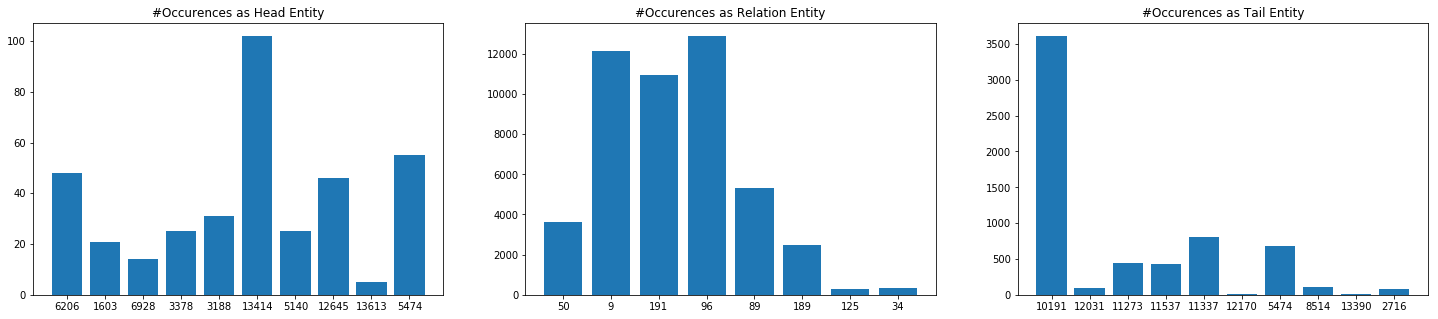

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

names = list(map(str, count_head_entities_worst.keys()))
values = list(map(int, count_head_entities_worst.values()))
axes[0].bar(names, values)
axes[0].set_title('#Occurences as Head Entity')

names = list(map(str, count_relations_worst.keys()))
values = list(map(int, count_relations_worst.values()))
axes[1].bar(names, values)
axes[1].set_title('#Occurences as Relation Entity')

names = list(map(str, count_tail_entities_worst.keys()))
values = list(map(int, count_tail_entities_worst.values()))
axes[2].bar(names, values)
axes[2].set_title('#Occurences as Tail Entity')

In [21]:
# analyse best_predictions_head.pkl
path = os.path.join(model_output_path, 'best_predictions_head.pkl')
best_predictions_head = pd.read_pickle(path)
best_predictions_head['rank'] = pd.to_numeric(best_predictions_head['rank'], downcast='integer')

print(best_predictions_head.head(10).to_string(index=False))

count_head_entities_best = dict()
count_relations_best = dict()
count_tail_entities_best = dict()

for triple in best_predictions_head['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_best[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_best[relation_id] = count_relations_train[relation_id]
    count_tail_entities_best[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_best))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_best))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_best))

print('\n\nHint: There are {} head predictions with rank 1'.format(prediction_table_perfect_h.shape[0]))

              triple  rank
    [9626  201 3951]     1
 [ 5527    34 11879]     1
    [2005  236 7594]     1
 [13327    14  8213]     1
    [5592  105 5346]     1
    [1399   59 6492]     1
    [ 815   57 9824]     1
    [9444   89 5359]     1
    [3152  176 9818]     1
 [10213    68 12735]     1

number of occurrences of this head entities in the training data (as head): {9626: 16, 5527: 5, 2005: 0, 13327: 16, 5592: 52, 1399: 17, 815: 25, 9444: 30, 3152: 45, 10213: 17}

number of occurrences of this relations in the training data: {201: 676, 34: 349, 236: 411, 14: 2992, 105: 966, 59: 2640, 57: 728, 89: 5305, 176: 797, 68: 9494}

number of occurrences of this tail entities in the training data (as tail): {3951: 11, 11879: 7, 7594: 411, 8213: 9, 5346: 12, 6492: 21, 9824: 56, 5359: 175, 9818: 168, 12735: 17}


Hint: There are 2660 head predictions with rank 1


Text(0.5, 1.0, '#Occurences as Tail Entity')

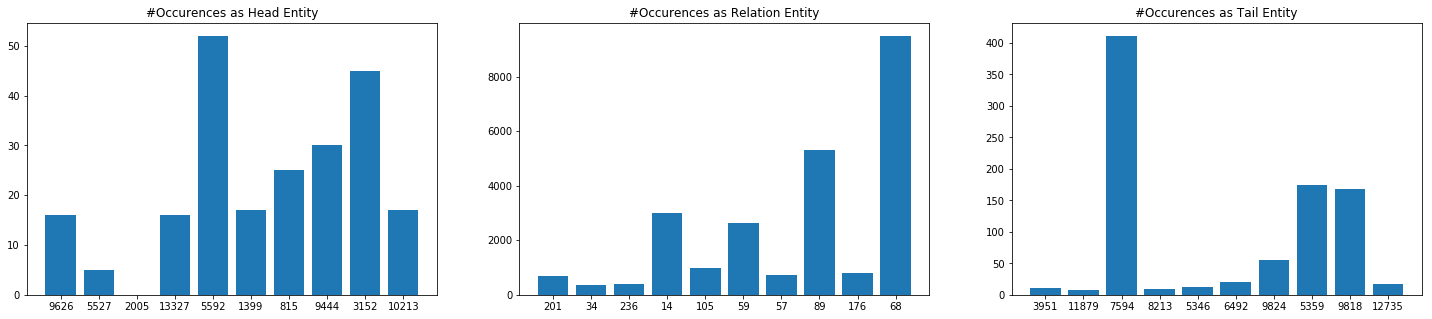

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

names = list(map(str, count_head_entities_best.keys()))
values = list(map(int, count_head_entities_best.values()))
axes[0].bar(names, values)
axes[0].set_title('#Occurences as Head Entity')

names = list(map(str, count_relations_best.keys()))
values = list(map(int, count_relations_best.values()))
axes[1].bar(names, values)
axes[1].set_title('#Occurences as Relation Entity')

names = list(map(str, count_tail_entities_best.keys()))
values = list(map(int, count_tail_entities_best.values()))
axes[2].bar(names, values)
axes[2].set_title('#Occurences as Tail Entity')

In [23]:
# analyse best_predictions_tail.pkl
path = os.path.join(model_output_path, 'best_predictions_tail.pkl')
best_predictions_tail = pd.read_pickle(path)
best_predictions_tail['rank'] = pd.to_numeric(best_predictions_tail['rank'], downcast='integer')

print(best_predictions_tail.head(10).to_string(index=False))

count_head_entities_best = dict()
count_relations_best = dict()
count_tail_entities_best = dict()

count_entities_best = dict()
count_relations_best = dict()
for triple in best_predictions_tail['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_best[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_best[relation_id] = count_relations_train[relation_id]
    count_tail_entities_best[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_best))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_best))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_best))

print('\n\nHint: There are {} tail predictions with rank 1'.format(prediction_table_perfect_t.shape[0]))

              triple  rank
 [ 4471   129 13510]     1
    [8690    3 7821]     1
    [9400  190 5317]     1
 [13707   138 10559]     1
 [13244   161  3785]     1
    [1276    5 2486]     1
    [3009  115   85]     1
    [5770   57 6963]     1
    [ 702   10 1566]     1
 [ 9280   215 13045]     1

number of occurrences of this head entities in the training data (as head): {4471: 273, 8690: 13, 9400: 31, 13707: 4, 13244: 147, 1276: 24, 3009: 19, 5770: 17, 702: 230, 9280: 36}

number of occurrences of this relations in the training data: {129: 5201, 3: 9465, 190: 3738, 138: 373, 161: 490, 5: 2834, 115: 1908, 57: 728, 10: 15989, 215: 423}

number of occurrences of this tail entities in the training data (as tail): {13510: 1, 7821: 9, 5317: 62, 10559: 4285, 3785: 10, 2486: 68, 85: 6, 6963: 10, 1566: 86, 13045: 31}


Hint: There are 6375 tail predictions with rank 1


In [24]:
# analyse compare_head_tail.pkl
print('is the model better in predicting heads or tails?')
path = os.path.join(model_output_path, 'compare_head_tail.pkl')
compare_head_tail_df = pd.read_pickle(path)
display(compare_head_tail_df.round(3).style.hide_index())

is the model better in predicting heads or tails?


metric,heads and tails,only heads,only tails
MR,292.326,386.075,198.578
MRR,0.306,0.207,0.406
HITS@1,0.221,0.13,0.311
HITS@3,0.336,0.225,0.448
HITS@10,0.478,0.363,0.593



statistical values:


,entity_id,average position
count,14541.0,14541.0
mean,7270.0,7270.0
std,4197.8,1641.4
min,0.0,1504.2
25%,3635.0,6303.6
50%,7270.0,7490.4
75%,10905.0,8415.9
max,14540.0,12607.1




entities with lowest average position (top 10):


entity_name,average position,count head in train,count head in test
Spinefarm Records,1504,0,1
Tour de France,1511,0,0
James E. Sullivan Award,1512,0,1
Australian Greens,1513,0,1
Padma Vibhushan,1514,0,1
nazism,1517,0,1
Kosi Zone,1517,0,0
commissioner,1518,0,1
Ocean Software,1520,0,1
Governor of Massachusetts,1520,0,0


Hint: "count head in train" = number of occurrences of the entities in the training data (as head)
"count head in test" = number of occurrences of the entities in the test data (as head)


entities with highest average position (last 10):


entity_name,average position,count head in train,count head in test
National Film Registry,11754,0,0
drama film,11755,394,14
television producer,11757,1,0
musical film,11852,72,1
United States Department of Housing and Urban Development,11891,1,0
pound sterling,11983,1,0
35 mm film,12059,0,0
fantasy,12078,136,3
comedy,12317,0,0
politician,12607,0,0


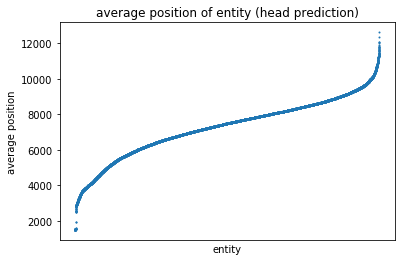

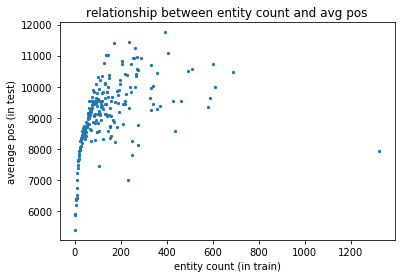

In [25]:
# analyse avg_position_table_head.pkl
path = os.path.join(model_output_path, 'avg_position_table_head.pkl')
avg_position_table_head = pd.read_pickle(path)

count_entities_highest = dict()  # train data
count_entities_highest_t = dict()  # test data
for entity_id in avg_position_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]
    count_entities_highest_t[entity_name] = count_head_entities_test[entity_id]

count_entities_lowest = dict()
count_entities_lowest_t = dict()
for entity_id in avg_position_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]
    count_entities_lowest_t[entity_name] = count_head_entities_test[entity_id]

print('\nstatistical values:')
display(avg_position_table_head.describe().round(1))
print('\n\nentities with lowest average position (top 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_head_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_head_tmp['entity_name'] = entity_names
avg_position_table_head_tmp['average position'] = average_positions

avg_position_table_head_tmp['count head in train'] = avg_position_table_head_tmp['entity_name'].\
                                                     map(count_entities_highest)
avg_position_table_head_tmp['count head in test'] = avg_position_table_head_tmp['entity_name'].\
                                                    map(count_entities_highest_t)
display(avg_position_table_head_tmp.style.hide_index())
print('Hint: \"count head in train\" = number of occurrences of the entities in the training data (as head)')
print('\"count head in test\" = number of occurrences of the entities in the test data (as head)')

print('\n\nentities with highest average position (last 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_head_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_head_tmp['entity_name'] = entity_names
avg_position_table_head_tmp['average position'] = average_positions

avg_position_table_head_tmp['count head in train'] = avg_position_table_head_tmp['entity_name'].\
                                                     map(count_entities_lowest)
avg_position_table_head_tmp['count head in test'] = avg_position_table_head_tmp['entity_name'].\
                                                    map(count_entities_lowest_t)
display(avg_position_table_head_tmp.style.hide_index())
print()

y = avg_position_table_head['average position']
x = np.arange(len(y))
plt.figure()
plt.title('average position of entity (head prediction)')
plt.xlabel('entity')
plt.ylabel('average position')
plt.xticks([])
plt.scatter(x, y, s=1)
plt.show()

entity_count_to_avg_pos = dict()
for index, row in avg_position_table_head.iterrows():
    entity_count = count_head_entities_train[row['entity_id']]
    if entity_count not in entity_count_to_avg_pos:
        entity_count_to_avg_pos[entity_count] = (row['average position'], 1)
    else:
        entity_count_to_avg_pos[entity_count] = (entity_count_to_avg_pos[entity_count][0]
                                                 + row['average position'],
                                                 entity_count_to_avg_pos[entity_count][1] + 1)

for entity_count, (sum_avg_pos, num) in entity_count_to_avg_pos.items():
    entity_count_to_avg_pos[entity_count] = sum_avg_pos / num

x = []
y = []
for entity_count in sorted(entity_count_to_avg_pos):
    x.append(entity_count)
    y.append(entity_count_to_avg_pos[entity_count])    
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id

plt.figure()
plt.title('relationship between entity count and avg pos')
plt.xlabel('entity count (in train)')
plt.ylabel('average pos (in test)')
plt.scatter(x, y, s=5)
plt.show()


statistical values:



,entity_id,average position
count,14541.0,14541.0
mean,7270.0,7270.0
std,4197.8,1934.9
min,0.0,758.6
25%,3635.0,6059.3
50%,7270.0,7527.8
75%,10905.0,8681.8
max,14540.0,11917.7




entities with lowest average position (top 10):


entity_name,average position,count tail in train,count tail in test
Ontario New Democratic Party,759,0,0
Lasker-DeBakey Clinical Medical Research Award,760,0,0
Governor of Massachusetts,761,0,0
Spinefarm Records,761,0,0
asteroid,761,0,0
Australian Greens,763,0,0
James E. Sullivan Award,767,0,0
Tour de France,768,0,2
Padma Vibhushan,770,0,0
nazism,771,0,0


Hint: "count tail in train" = number of occurrences of the entities in the training data (as tail)
"count tail in test" = number of occurrences of the entities in the test data (as tail)


entities with highest average position (last 10):


entity_name,average position,count tail in train,count tail in test
wide receiver,11631,178,0
Kelly Macdonald,11640,78,2
Freddy Rodriguez,11681,41,0
Central European Time,11686,123,14
chancellor,11762,0,0
chief executive officer,11788,0,0
Julianna Margulies,11794,33,0
comedy,11794,610,60
Brian Baumgartner,11796,31,2
politician,11918,99,9


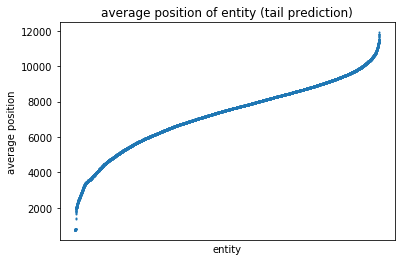

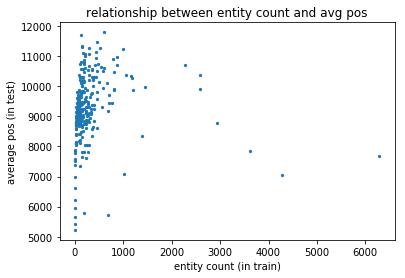

In [26]:
# analyse avg_position_table_tail.pkl
path = os.path.join(model_output_path, 'avg_position_table_tail.pkl')
avg_position_table_tail = pd.read_pickle(path)

count_entities_highest = dict()  # train data
count_entities_highest_t = dict()  # test data
for entity_id in avg_position_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]
    count_entities_highest_t[entity_name] = count_tail_entities_test[entity_id]

count_entities_lowest = dict()
count_entities_lowest_t = dict()
for entity_id in avg_position_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]
    count_entities_lowest_t[entity_name] = count_tail_entities_test[entity_id]

print('\nstatistical values:\n')
display(avg_position_table_tail.describe().round(1))

print('\n\nentities with lowest average position (top 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_tail_tmp['entity_name'] = entity_names
avg_position_table_tail_tmp['average position'] = average_positions

avg_position_table_tail_tmp['count tail in train'] = avg_position_table_tail_tmp['entity_name'].\
                                                     map(count_entities_highest)
avg_position_table_tail_tmp['count tail in test'] = avg_position_table_tail_tmp['entity_name'].\
                                                    map(count_entities_highest_t)
display(avg_position_table_tail_tmp.style.hide_index())
print('Hint: \"count tail in train\" = number of occurrences of the entities in the training data (as tail)')
print('\"count tail in test\" = number of occurrences of the entities in the test data (as tail)')

print('\n\nentities with highest average position (last 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_tail_tmp['entity_name'] = entity_names
avg_position_table_tail_tmp['average position'] = average_positions

avg_position_table_tail_tmp['count tail in train'] = avg_position_table_tail_tmp['entity_name'].\
                                                     map(count_entities_lowest)
avg_position_table_tail_tmp['count tail in test'] = avg_position_table_tail_tmp['entity_name'].\
                                                    map(count_entities_lowest_t)
display(avg_position_table_tail_tmp.style.hide_index())
print()

y = avg_position_table_tail['average position']
x = np.arange(len(y))
plt.figure()
plt.title('average position of entity (tail prediction)')
plt.xlabel('entity')
plt.ylabel('average position')
plt.xticks([])
plt.scatter(x, y, s=1)
plt.show()

entity_count_to_avg_pos = dict()
for index, row in avg_position_table_tail.iterrows():
    entity_count = count_tail_entities_train[row['entity_id']]
    if entity_count not in entity_count_to_avg_pos:
        entity_count_to_avg_pos[entity_count] = (row['average position'], 1)
    else:
        entity_count_to_avg_pos[entity_count] = (entity_count_to_avg_pos[entity_count][0] +
                                                 row['average position'],
                                                 entity_count_to_avg_pos[entity_count][1] + 1)

for entity_count, (sum_avg_pos, num) in entity_count_to_avg_pos.items():
    entity_count_to_avg_pos[entity_count] = sum_avg_pos / num

x = []
y = []
for entity_count in sorted(entity_count_to_avg_pos):
    x.append(entity_count)
    y.append(entity_count_to_avg_pos[entity_count])

plt.figure()
plt.title('relationship between entity count and avg pos')
plt.xlabel('entity count (in train)')
plt.ylabel('average pos (in test)')
plt.scatter(x, y, s=5)
plt.show()

In [27]:
# analyse highly_ranked_table_head.pkl
path = os.path.join(model_output_path, 'highly_ranked_table_head.pkl')
highly_ranked_table_head = pd.read_pickle(path)

entity_in_top10_count_head = defaultdict(int)
for index, row in highly_ranked_table_head.iterrows():
    entity_in_top10_count_head[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in highly_ranked_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in highly_ranked_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]

print('\nstatistical values:\n')
display(highly_ranked_table_head.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity gets a position between 1 and 10)\n')
entity_names = []
counts = []
for index, row in highly_ranked_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_head_tmp['entity_name'] = entity_names
highly_ranked_table_head_tmp['count'] = counts

highly_ranked_table_head_tmp['count head in train'] = highly_ranked_table_head_tmp['entity_name'].\
                                                      map(count_entities_highest)
display(highly_ranked_table_head_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity gets a position between 1 and 10)\n')
entity_names = []
counts = []
for index, row in highly_ranked_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_head_tmp['entity_name'] = entity_names
highly_ranked_table_head_tmp['count'] = counts

highly_ranked_table_head_tmp['count head in train'] = highly_ranked_table_head_tmp['entity_name'].\
                                                      map(count_entities_lowest)
display(highly_ranked_table_head_tmp.style.hide_index())

mask = highly_ranked_table_head['count'] > 100
num = highly_ranked_table_head[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = highly_ranked_table_head['count'] == 0
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = highly_ranked_table_head['count'] == 1
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = highly_ranked_table_head['count'] < 10
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,10640.0,10640.0
mean,7244.6,19.2
std,4196.0,37.7
min,1.0,1.0
25%,3639.8,2.0
50%,7243.0,7.0
75%,10899.2,19.0
max,14539.0,502.0




entities with highest count (top 10)
(shows how often the respective entity gets a position between 1 and 10)



entity_name,count,count head in train
20th Century Fox,502,230
Golden Globe Cecil B. DeMille Award,467,57
Gary Oldman,438,49
basketball,437,48
cycling,436,56
Rock and Roll Hall of Fame,433,85
Oliver Stone,419,48
Mountain Time Zone,417,0
Pacific Time Zone,414,0
Michael Mann,413,30




entities with lowest count (last 10)
(shows how often the respective entity gets a position between 1 and 10)



entity_name,count,count head in train
Blazing Saddles,1,17
The Muppet Movie,1,14
Yul Brynner,1,7
Ray Walston,1,19
Barry Pepper,1,36
shock rock,1,6
Tombstone,1,13
Easton,1,5
Wilkes-Barre,1,7
Maidstone,1,0



number of entities with count > 100: 371
number of entities with count 0: 0
number of entities with count 1: 1612
number of entities with count < 10: 6287


In [28]:
# analyse highly_ranked_table_tail.pkl
path = os.path.join(model_output_path, 'highly_ranked_table_tail.pkl')
highly_ranked_table_tail = pd.read_pickle(path)

entity_in_top10_count_tail = defaultdict(int)
for index, row in highly_ranked_table_tail.iterrows():
    entity_in_top10_count_tail[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in highly_ranked_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]
    
count_entities_lowest = dict()
for entity_id in highly_ranked_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]

print('\nstatistical values:\n')
display(highly_ranked_table_tail.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity gets a position between 1 and 10)')
entity_names = []
counts = []
for index, row in highly_ranked_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_tail_tmp['entity_name'] = entity_names
highly_ranked_table_tail_tmp['count'] = counts

highly_ranked_table_tail_tmp['count tail in train'] = highly_ranked_table_tail_tmp['entity_name'].\
                                                      map(count_entities_highest)
display(highly_ranked_table_tail_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity gets a position between 1 and 10)')
entity_names = []
counts = []
for index, row in highly_ranked_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_tail_tmp['entity_name'] = entity_names
highly_ranked_table_tail_tmp['count'] = counts

highly_ranked_table_tail_tmp['count tail in train'] = highly_ranked_table_tail_tmp['entity_name'].\
                                                      map(count_entities_lowest)
display(highly_ranked_table_tail_tmp.style.hide_index())

mask = highly_ranked_table_tail['count'] > 100
num = highly_ranked_table_tail[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = highly_ranked_table_tail['count'] == 0
num = highly_ranked_table_tail[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = highly_ranked_table_tail['count'] == 1
num = highly_ranked_table_tail[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = highly_ranked_table_tail['count'] < 10
num = highly_ranked_table_tail[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,10937.0,10937.0
mean,7281.9,18.7
std,4205.2,48.0
min,0.0,1.0
25%,3642.0,2.0
50%,7301.0,6.0
75%,10944.0,17.0
max,14538.0,1038.0




entities with highest count (top 10)
(shows how often the respective entity gets a position between 1 and 10)


entity_name,count,count tail in train
United States of America,1038,6289
Canada,904,683
United Kingdom,772,1443
Los Angeles,697,684
actor,691,2271
film producer,676,864
Germany,659,705
New Zealand,654,299
France,621,772
screenwriter,617,872




entities with lowest count (last 10)
(shows how often the respective entity gets a position between 1 and 10)


entity_name,count,count tail in train
Harry Connick Jr.,1,13
Josh Hutcherson,1,13
anti-folk,1,0
Kyle Chandler,1,22
Abe Burrows,1,6
Mitchell Hurwitz,1,7
Danny Trejo,1,1
Cheech Marin,1,3
Forgetting Sarah Marshall,1,14
Graham Chapman,1,7



number of entities with count > 100: 300
number of entities with count 0: 0
number of entities with count 1: 1629
number of entities with count < 10: 6779


In [29]:
# analyse top_ranked_table_head.pkl
path = os.path.join(model_output_path, 'top_ranked_table_head.pkl')
top_ranked_table_head = pd.read_pickle(path)

entity_first_place_count_head = defaultdict(int)
for index, row in top_ranked_table_head.iterrows():
    entity_first_place_count_head[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in top_ranked_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in top_ranked_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]

print('\nstatistical values:\n')
display(top_ranked_table_head.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity is on the first place in models ranking)\n')
entity_names = []
counts = []
for index, row in top_ranked_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_head_tmp['entity_name'] = entity_names
top_ranked_table_head_tmp['count'] = counts

top_ranked_table_head_tmp['count head in train'] = top_ranked_table_head_tmp['entity_name'].\
                                                   map(count_entities_highest)
display(top_ranked_table_head_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity is on the first place in models ranking)\n')
entity_names = []
counts = []
for index, row in top_ranked_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_head_tmp['entity_name'] = entity_names
top_ranked_table_head_tmp['count'] = counts

top_ranked_table_head_tmp['count head in train'] = top_ranked_table_head_tmp['entity_name'].\
                                                   map(count_entities_lowest)
display(top_ranked_table_head_tmp.style.hide_index())

mask = top_ranked_table_head['count'] > 100
num = top_ranked_table_head[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = top_ranked_table_head['count'] == 0
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = top_ranked_table_head['count'] == 1
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = top_ranked_table_head['count'] < 10
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,3799.0,3799.0
mean,7247.2,5.4
std,4160.2,15.4
min,10.0,1.0
25%,3616.0,1.0
50%,7264.0,2.0
75%,10871.0,4.0
max,14537.0,404.0




entities with highest count (top 10)
(shows how often the respective entity is on the first place in models ranking)



entity_name,count,count head in train
Michael Mann,404,30
Judy Greer,333,20
Eriq La Salle,299,27
John Hughes,297,16
Hal Smith,215,9
Apocalypto,182,19
Willow,150,20
Blues Brothers 2000,144,17
United States of America,141,1325
Henry Winkler,115,26




entities with lowest count (last 10)
(shows how often the respective entity is on the first place in models ranking)



entity_name,count,count head in train
Ryan Tedder,1,31
Liv Ullmann,1,17
Errol Flynn,1,16
literature‎,1,7
Barry Pepper,1,36
Law & Order: Special Victims Unit,1,17
Haverhill,1,7
Lycoming County,1,4
Graham Gouldman,1,20
French and Indian War,1,12



number of entities with count > 100: 11
number of entities with count 0: 0
number of entities with count 1: 1650
number of entities with count < 10: 3351


In [30]:
# analyse top_ranked_table_tail.pkl
path = os.path.join(model_output_path, 'top_ranked_table_tail.pkl')
top_ranked_table_tail = pd.read_pickle(path)

entity_first_place_count_tail = defaultdict(int)
for index, row in top_ranked_table_tail.iterrows():
    entity_first_place_count_tail[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in top_ranked_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in top_ranked_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]

print('\nstatistical values:\n')
display(top_ranked_table_tail.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity is on the first place in models ranking)')
entity_names = []
counts = []
for index, row in top_ranked_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_tail_tmp['entity_name'] = entity_names
top_ranked_table_tail_tmp['count'] = counts

top_ranked_table_tail_tmp['count tail in train'] = top_ranked_table_tail_tmp['entity_name'].\
                                                   map(count_entities_highest)
display(top_ranked_table_tail_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity is on the first place in models ranking)')
entity_names = []
counts = []
for index, row in top_ranked_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_tail_tmp['entity_name'] = entity_names
top_ranked_table_tail_tmp['count'] = counts

top_ranked_table_tail_tmp['count tail in train'] = top_ranked_table_tail_tmp['entity_name'].\
                                                   map(count_entities_lowest)
display(top_ranked_table_tail_tmp.style.hide_index())

mask = top_ranked_table_tail['count'] > 100
num = top_ranked_table_tail[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = top_ranked_table_tail['count'] == 0
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = top_ranked_table_tail['count'] == 1
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = top_ranked_table_tail['count'] < 10
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,3576.0,3576.0
mean,7246.3,5.7
std,4092.9,21.7
min,13.0,1.0
25%,3850.0,1.0
50%,7360.0,2.0
75%,10784.0,4.0
max,14530.0,765.0




entities with highest count (top 10)
(shows how often the respective entity is on the first place in models ranking)


entity_name,count,count tail in train
United States of America,765,6289
10191,402,3612
male organism,376,2928
English,341,2590
marriage,318,2586
actor,292,2271
United States dollar,271,4285
Los Angeles,195,684
DVD,160,1388
New York City,146,1010




entities with lowest count (last 10)
(shows how often the respective entity is on the first place in models ranking)


entity_name,count,count tail in train
Anaheim,1,13
Takoma Park,1,6
72nd Academy Awards,1,20
Judd Apatow,1,36
Golden Reel Award,1,7
Kevin Kline,1,25
Ingmar Bergman,1,14
Michael Cera,1,7
1622,1,11
Lycoming County,1,3



number of entities with count > 100: 15
number of entities with count 0: 0
number of entities with count 1: 1530
number of entities with count < 10: 3192


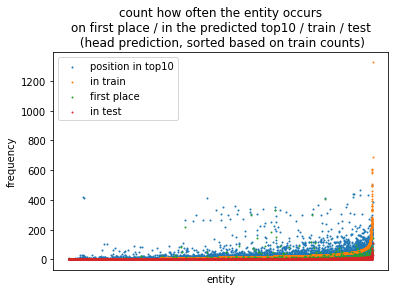

most intersting section:


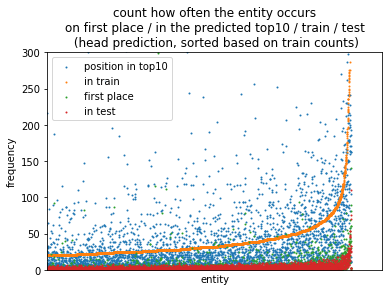


entities that were predicted far too often:


entity,true head count,pred head count,difference,head in train count,entity in train count
Michael Mann,2,404,402,30,56
Judy Greer,0,333,333,20,26
Eriq La Salle,1,299,298,27,44
John Hughes,1,297,296,16,30
Hal Smith,0,215,215,9,12
Apocalypto,2,182,180,19,29
Willow,0,150,150,20,33
Blues Brothers 2000,0,144,144,17,30
Henry Winkler,2,115,113,26,36
Isabella Rossellini,0,112,112,27,34




entities that were predicted far too seldom:


entity,true head count,pred head count,difference,head in train count,entity in train count
master's degree,36,10,-26,243,243
drum kit,45,24,-21,338,516
Academy Award for Best Actor,30,15,-15,271,458
Hellboy,15,0,-15,67,78
The Hunger Games,14,1,-13,68,81
BAFTA Award for Best Makeup and Hair,17,4,-13,91,119
The Pianist,12,0,-12,56,81
Wreck-It Ralph,12,0,-12,50,62
Academy Award for Best Supporting Actor,22,11,-11,269,464
A Prophet,11,0,-11,42,47


In [31]:
# head prediction: plot how often the entity occurs in the predicted top10 / on first place / train / 
# test (sorted based on train counts)
y_train = []
y_test = []
y_predicted_top10 = []
y_predicted_top1 = []

all_entities = list(id2entity.keys())
all_head_entities_train = list(count_head_entities_train.keys())
entities_not_head_in_train = np.setdiff1d(all_entities, all_head_entities_train)
assert len(all_entities) == len(entities_not_head_in_train) + len(all_head_entities_train)

for entity_id in entities_not_head_in_train:
    y_train.append(count_head_entities_train[entity_id])
    y_test.append(count_head_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_head[entity_id])
    y_predicted_top1.append(entity_first_place_count_head[entity_id])

for entity_id in sorted(count_head_entities_train, key=count_head_entities_train.get):
    y_train.append(count_head_entities_train[entity_id])
    y_test.append(count_head_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_head[entity_id])
    y_predicted_top1.append(entity_first_place_count_head[entity_id])
    
assert len(y_train) == len(y_test)
assert len(y_test) == len(y_predicted_top10)
assert len(y_test) == len(y_predicted_top1)
x = [i for i in range(len(y_train))]

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (head prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.show()

print('most intersting section:')

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (head prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.axis([10000, 15000, 0, 300])  # xmin, xmax, ymin, ymax
plt.show()

entity_ids = []
differences = []  # difference between count predicted and count true
true_head_counts = []
pred_head_counts = []
head_in_train_counts = []
entity_in_train_counts = []

for entity_id in id2entity.keys():
    entity_ids.append(entity_id)
    true_head_counts.append(count_head_entities_test[entity_id])
    pred_head_counts.append(entity_first_place_count_head[entity_id])
    difference = entity_first_place_count_head[entity_id] - count_head_entities_test[entity_id]
    differences.append(difference)
    head_in_train_counts.append(count_head_entities_train[entity_id])
    entity_in_train_counts.append(count_head_entities_train[entity_id]
                                  + count_tail_entities_train[entity_id])

entity_names = []
for entity_id in entity_ids:
    try:
        entity_name = mid2name[id2entity[entity_id]]
        if len(entity_name) > 39:
            entity_name = entity_name[:39] + '...'
        entity_names.append(entity_name)
    except:
        entity_names.append(entity_id)

difference_df = pd.DataFrame(columns=['entity', 'true head count', 'pred head count', 'difference', 
                                      'head in train count', 'entity in train count'])
difference_df['entity'] = entity_names
difference_df['true head count'] = true_head_counts
difference_df['pred head count'] = pred_head_counts
difference_df['difference'] = differences
difference_df['head in train count'] = head_in_train_counts
difference_df['entity in train count'] = entity_in_train_counts
difference_df = difference_df.sort_values(by='difference', ascending=False)

print('\nentities that were predicted far too often:')
display(difference_df.head(10).style.hide_index())
print('\n\nentities that were predicted far too seldom:')
display(difference_df.tail(10).sort_values(by='difference').style.hide_index())

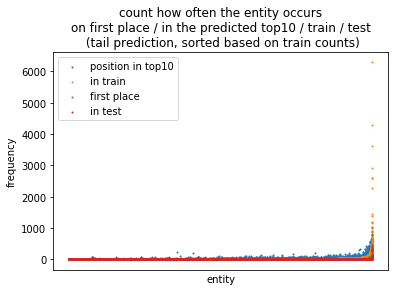

most intersting section:


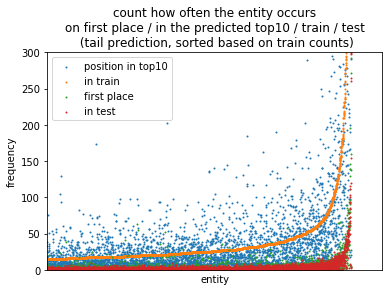


entities that were predicted far too often:


entity,true tail count,pred tail count,difference,tail in train count,entity in train count
United States of America,454,765,311,6289,7614
Los Angeles,73,195,122,684,739
New York City,73,146,73,1010,1077
Palm Springs,2,63,61,19,26
Allahabad University,0,58,58,13,23
Jason Reitman,0,55,55,19,52
mathematics,11,65,54,130,147
Kuwait,12,66,54,153,170
London,29,83,54,389,464
Hong Kong,36,90,54,360,406




entities that were predicted far too seldom:


entity,true tail count,pred tail count,difference,tail in train count,entity in train count
Australia,65,21,-44,538,661
female organism,103,62,-41,811,811
Argentina,46,7,-39,376,421
sound editor,41,10,-31,321,321
Hungary,40,10,-30,343,411
Poland,30,3,-27,359,449
Denmark,51,24,-27,360,415
Austria,29,3,-26,232,316
physics,24,1,-23,102,113
Israel,35,12,-23,250,279


In [32]:
# tail prediction: plot how often the entity occurs in the predicted top10 / on first place / train /
# test (sorted based on train counts)
y_train = []
y_test = []
y_predicted_top10 = []
y_predicted_top1 = []

all_tail_entities_train = list(count_tail_entities_train.keys())
entities_not_tail_in_train = np.setdiff1d(all_entities, all_tail_entities_train)
assert len(all_entities) == len(entities_not_tail_in_train) + len(all_tail_entities_train)

for entity_id in entities_not_tail_in_train:
    y_train.append(count_tail_entities_train[entity_id])
    y_test.append(count_tail_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_tail[entity_id])
    y_predicted_top1.append(entity_first_place_count_tail[entity_id])

for entity_id in sorted(count_tail_entities_train, key=count_tail_entities_train.get):
    y_train.append(count_tail_entities_train[entity_id])
    y_test.append(count_tail_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_tail[entity_id])
    y_predicted_top1.append(entity_first_place_count_tail[entity_id])
    
assert len(y_train) == len(y_test)
assert len(y_test) == len(y_predicted_top10)
assert len(y_test) == len(y_predicted_top1)
x = [i for i in range(len(y_train))]

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (tail prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.show()

print('most intersting section:')

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (tail prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.axis([10000, 15000, 0, 300])  # xmin, xmax, ymin, ymax
plt.show()

entity_ids = []
differences = []  # difference between count predicted and count true
true_tail_counts = []
pred_tail_counts = []
tail_in_train_counts = []
entity_in_train_counts = []

for entity_id in id2entity.keys():
    entity_ids.append(entity_id)
    true_tail_counts.append(count_tail_entities_test[entity_id])
    pred_tail_counts.append(entity_first_place_count_tail[entity_id])
    difference = entity_first_place_count_tail[entity_id] - count_tail_entities_test[entity_id]
    differences.append(difference)
    tail_in_train_counts.append(count_tail_entities_train[entity_id])
    entity_in_train_counts.append(count_head_entities_train[entity_id]
                                  + count_tail_entities_train[entity_id])

entity_names = []
for entity_id in entity_ids:
    try:
        entity_name = mid2name[id2entity[entity_id]]
        if len(entity_name) > 39:
            entity_name = entity_name[:39] + '...'
        entity_names.append(entity_name)
    except:
        entity_names.append(entity_id)

difference_df = pd.DataFrame(columns=['entity', 'true tail count', 'pred tail count', 'difference', 
                                      'tail in train count', 'entity in train count'])
difference_df['entity'] = entity_names
difference_df['true tail count'] = true_tail_counts
difference_df['pred tail count'] = pred_tail_counts
difference_df['difference'] = differences
difference_df['tail in train count'] = tail_in_train_counts
difference_df['entity in train count'] = entity_in_train_counts
difference_df = difference_df.sort_values(by='difference', ascending=False)

print('\nentities that were predicted far too often:')
display(difference_df.head(10).style.hide_index())
print('\n\nentities that were predicted far too seldom:')
display(difference_df.tail(10).sort_values(by='difference').style.hide_index())